In [1]:
# ## uncomment the following lines if you use  Google cloud  Colabs
# import sys
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# root="/content/drive/MyDrive/Colab Notebooks/interviews-technical-challenge/MultiClass-classification/"; sys.path.append(root)
# %cd $root
# !ls

In [2]:
%%capture
pip install pandasql

In [110]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
plt.rcParams.update({'font.size': 22})

import seaborn as sns
import datetime
import plotly
import plotly.offline as py
import plotly.graph_objs as go
from pandasql import sqldf

# load the dataset

In [4]:
filename = 'data/RetentionData.csv'
target_var= 'Retained'

# algorithm parameters
lamda=2
horizon=5

# I. Designed algorithm 

In this project, we will design prediction system using Autoregression technique. 
The algrithm will assign a score defining the (positive/negative) trend of the students retention. 
The Autoregression model will return score defining the trends of retain specific program by international and domestic students. 
<h3> <p style="text-align:center;">  $ score =  \displaystyle\sum_{i=0}^H   W_i \times x_i~~~~~~~~~~~$         where        $~~~~~~~~~~~W_i = \frac{1}{\lambda^i} \Delta x_i = \frac{1}{\lambda^i} (x_i - x_{i-1})$  </p> </h3>
<p>  $H$ is the scoring horizon/windows. It defines the number of past values to be considered in the scoring equation. The larger the windows the longer the scoring memory becomes. Thus, the previous drops will significantly influence the future trend.  </p> 
<p> $\lambda$ =2is the autoregression coefficient defining a short term memory of the significance of the past values. </p> 

For example, $\lambda=2$ means that contribution to the future predicted values will be devided by $2$ each time as we move backward in the scoring horison as we move 

## 1. Load the data

In [5]:
df = pd.read_csv(filename)
df=df.drop_duplicates()
# visualize the dataset
print(f'\nView random rows from the dataset [shape = {df.shape}]...\n')
df.sample(n=5)


View random rows from the dataset [shape = (746, 6)]...



,AdmitTerm,School,Program,NationalStatus,Enrolled,Retained
188,Fall 2018,School B,XEM,DOMESTIC,66,58.0
719,Fall 2023,School E,NGF,INTERNATIONAL,8,6.0
229,Fall 2018,School D,RNV,DOMESTIC,18,18.0
546,Fall 2022,School B,TWJ,DOMESTIC,11,5.0
252,Fall 2018,School D,THM,DOMESTIC,24,23.0


In [6]:
df['retention rate']=100*df['Retained']/df['Enrolled']
df.sample(n=5)

,AdmitTerm,School,Program,NationalStatus,Enrolled,Retained,retention rate
704,Fall 2023,School C,LBR,INTERNATIONAL,1,1.0,100.000000
342,Fall 2019,School D,ZCU,DOMESTIC,14,13.0,92.857143
350,Fall 2019,School B,ENR,INTERNATIONAL,3,3.0,100.000000
298,Fall 2019,School D,XLL,DOMESTIC,32,30.0,93.750000
59,Fall 2016,School E,PEW,DOMESTIC,77,65.0,84.415584


In [7]:
# View dataset info
df.info(show_counts=True)

# check the columns format
print('\n\n check the columns format')
pd.DataFrame(df.dtypes).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 7 columns):
 #  Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AdmitTerm       746 non-null    object 
 1   School          746 non-null    object 
 2   Program         746 non-null    object 
 3   NationalStatus  746 non-null    object 
 4   Enrolled        746 non-null    int64  
 5   Retained        746 non-null    float64
 6   retention rate  746 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 40.9+ KB


 check the columns format


,AdmitTerm,School,Program,NationalStatus,Enrolled,Retained,retention rate
0,object,object,object,object,int64,float64,float64


## 2. Functions

### 2.1 Scores and interpolation

In [8]:
def convert_list_quesry_format(input_list):
    return  "('" + "', '".join([str(item) for item in input_list]) + "')"

def compute_tending_score1(vect, lamda=2, horizon=3, verbose=0):
    # remove te nan values from the 
    # check the input parameters ranges
    assert lamda >1 , print(f"Wrong value lamda ={lamda}. The lamda value must be strictly greater than 1 ")
    assert len(vect) >=1, print(f"The horizon={horizon} cannot be applied to a shorther vector os size {len(vect)}. \
                                        \nplease input a vect signal of at lease  {horizon} values OR re duce the hosizon={len(vect)}")
    if len(vect)<=horizon:
        horizon=len(vect)-1
        print(f"horizon was modified to fit the input vector size of {horizon}")
    
    # assert horizon >2 , print(f"Wrong value horizon ={horizon}. The lamda value must be strictly greater than 1 ")
    if horizon<2:
        score_msg = f" score: NA (missing data!!)"
        # score_msg = f" score : NA [not enough samples ({len(vect)}) to compute the trend!!]"
        return np.nan, score_msg
    
    # 1/l^i  formula
    w=np.array([1/pow(lamda,horizon-i-1) for i in range(horizon)])
    # # Exponential decay formula
    # w=np.array([1- np.exp(-lamda*i) for i in range(horizon)])
    
    x=np.array(vect[-horizon:])
    actual_value= 1 if  x[-1]==0 else x[-1]
    x=x-x.min()
    
    # compute the weighted sum as a score
    score= np.dot(x,w)#- actual_value
    if verbose>0:
        print(f"x={x}")
        print(f"w={w}")
        print(f"score={score}")
        
    score_msg = f"Score={score:.2f} " #(l={lamda}, hz={horizon})"
    return float("{:.2f}".format(score)), score_msg

def compute_tending_score2(vect, lamda=2, horizon=3, verbose=0):
    diff_vect = np.diff(vect)
    assert lamda >1 , print(f"Wrong value lamda={lamda}. The lamda value must be greater than 1 ")
    
    assert len(vect) >=2, print(f"The horizon={horizon} cannot be applied to a shorther vector os size {len(vect)}. \
                                        \nplease input a vect signal of at lease  {horizon} values OR reduce the hosizon={len(vect)}")

    if len(vect)<=horizon:
        horizon=len(vect)-1
        print(f"horizon was modified to fit the input vector size of {horizon}")
    
    # assert horizon >2 , print(f"Wrong value horizon ={horizon}. The lamda value must be strictly greater than 1 ")
    if horizon<2:
        score_msg = f"Score=: NA (missing data!!)"
        # score_msg = f" score : NA [not enough samples ({len(vect)}) to compute the trend!!]"

        print(score_msg)
        return np.NaN, score_msg
    
    
    # compute the weighted sum as a score
    x=np.array(vect[-horizon:])

    w=np.array([1/pow(lamda,horizon-i-1) for i in range(horizon)])
    actual_value= 1 if  x[-1]==0 else x[-1]
    # x=x-x.min()
    
    diff_x=np.array(diff_vect[-horizon+1:])/actual_value
     
    # if len(w)==len(diff_x)+1:
    diff_x=np.concatenate((diff_x, np.array([1])))
    

    w2=np.multiply(w, diff_x)
    
    # compute the weighted sum as a score
    score2= np.dot(x,w2)# - actual_value
    if verbose>0:
        print(f"w={w}")  
        print(f"diff_x={diff_x}")
        print(f"w2=w*diff_x={w2}") 
        print(f"x={x}")
        print(f"score2={score2}")
        
    score2_msg = f"Score={score2:.2f}" # (l={lamda}, hz={horizon})"
    return float("{:.2f}".format(score2)), score2_msg

def fill_missing_values(terms, x, y):
    y_new=[np.nan for i in terms] #
    x=x.tolist()
    x_=terms.tolist()
    for val_x, val_y in zip(x, y):
        try:
            idx = x_.index(val_x)
            y_new[idx]= val_y
        except Exception as e:
            continue
            
    return terms.copy(), y_new
  
def interpolate_missing_values(vect, verbose=0):
    # initialization
    first_nan=False
    last_nan=False
    arr=vect.copy()
    # check format
    # if np.isnan(arr[-1]):
    #    print(f'The input array must have a valid last value but was given a last value of <{arr[-1]}> !!')
    #    return []
    N=len(arr)
    for i, x in enumerate(arr):
        # replace the first item with 0
        if np.isnan(x) and not first_nan:
            arr[i]=0
        else:
            first_nan=True
        
        # replace the last item with 0
        if np.isnan(arr[N-i-1]) and not first_nan:
            arr[N-i-1]=0
        else:
            first_nan=True   
            
            
    # replave the intermediate missing values using linear interepolation
    missing_indices = [i for i, x in enumerate(arr) if np.isnan(x)]
    
    # Iterate over each None index and replace it
    for i in missing_indices:
        # Find the nearest previous and next non-None values
        prev_index = next((j for j in range(i - 1, -1, -1) if not np.isnan(arr[j]) ), None)
        next_index = next((j for j in range(i + 1, len(arr)) if not np.isnan(arr[j])), None)
        
        if prev_index is not None and next_index is not None:
            # If both previous and next values are available, use linear interpolation
            intrp = arr[prev_index] + (arr[next_index] - arr[prev_index]) * (i - prev_index) / (next_index - prev_index)
            arr[i] = round(intrp, 3)
        elif prev_index is not None:
            # If only the previous value is available, use it
            arr[i] = arr[prev_index]
        elif next_index is not None:
            # If only the next value is available, use it
            arr[i] = arr[next_index]
    
    if verbose>0:   
        print(f'\t - y ={vect}')
        print(f'\t - y(interp) ={arr}')

    return arr

### 2.2 retention variartion and visualization

In [189]:
def view_label_distribution(df_y, title='Distribution'):
    '''
    View Diagnosis Distribution
    '''
    df_y = df_y.sort_values(ascending=False)

    fig = plt.figure(figsize=(15, 8))
    plt.title(title, fontsize=22)

    labels_distribution = df_y.value_counts().sort_index()  # .sort_values()
    # print(labels_distribution)

    # create pie chart
    plt.pie(labels_distribution.values,
            labels=labels_distribution.keys(),
            autopct='%.0f%%')
    text_params = {
      'x': 0,
      'y': 0,
      's': f"Total: {len(df)} samples",
      'size': 12,
      'color': "black",
      'ha': "center",
      'va': "center",
      'bbox': dict(boxstyle="round", fc=("lightgreen"), ec=("black"))
    }
    plt.text(**text_params);
    # plt.grid(False);
    # sns.despine();
    plt.show()


def plot_variation(df, var, target, title='', lamda=5, horizon=5):
    if title == '':
        title = 'Retention percentage  variation by ' + var
    # get the list of terms
    terms = df['AdmitTerm'].unique()
    # # print(f" - the recorded {len(terms)} terms are  {terms}" )
    # fig, ax = plt.subplots(2, sharex=True)
    # fig.suptitle(title)
    list_tags, list_scores, scores_label = [], [], []
    recent_retained, x_list, y_list, avg_y_list = [], [], [], []
    tag_missing, list_missing = [], []
    tag_labels = df[var].unique()
    tag_labels.sort()

    # define the experiment
    experiemnt = f'PartA_variation_{var}_{target}'
    # visualize the plots
    fig= plt.figure(figsize=(19.20, 10.80))

    for tag in tag_labels:

        if 'rate' in target:
            filter_tag= df.groupby(['AdmitTerm', var], as_index=False)[target].mean()
            filter_std= df.groupby(['AdmitTerm', var], as_index=False)[target].std()
        else:
            filter_tag= df.groupby(['AdmitTerm', var], as_index=False)[target].sum()
            filter_std= df.groupby(['AdmitTerm', var], as_index=False)[target].std()

        # get the mean and STD of the signals
        average_retention= filter_tag[filter_tag[var] == tag]
        average_retention= average_retention.sort_values(by=['AdmitTerm'], ascending=True)

        std_retention= filter_std[filter_std[var] == tag]
        std_retention= std_retention.sort_values(by=['AdmitTerm'], ascending=True)

        # print(average_retention)
        x= average_retention['AdmitTerm'].values
        y= average_retention[target].values
        y_std= std_retention[target].values

        # check the missing data
        missing_info= list(set(terms) - set(x))
        missing_info.sort()
        if len(missing_info) > 0:
            # print(f"\n - {len(missing_info)}/ {len(terms)} missing data of {var} -> {tag} at {missing_info}" )
            list_missing.append(missing_info)
            tag_missing.append(tag)

            
        # fill the missing values with 0
        x, y = fill_missing_values(terms, x, y)
        x, y = fill_missing_values(terms, x, y)

        # if np.isnan(y[-1]):
        #    print(f'warning: {tag} is skipped because the latest records were not provided. \
        #            \n it must me at lease of size 2.  ')


        # linear interpolation of the missing values
        y = interpolate_missing_values(y)

        # compute the score
        if len(y) >= 2:
            score, score_msg = compute_tending_score2(y, lamda=lamda, horizon=horizon, verbose=0)
        else:
            print(f'warning: {tag} is skipped because the scoring cannot be applied to a shorther vector os size {len(y)}. \
                    \nIt must me at lease of size 2.  ')
            continue

        # retreive the computed scores
        x_list.append(x)
        y_list.append(y)
        avg_y_list.append(round(np.mean(y[-horizon:]), 2))
        list_tags.append(tag)
        list_scores.append(score)
        scores_label.append(score_msg)
        recent_retained.append(round(y[-1], 2))

        # plot the curve of tag
        plt.plot(x, y, linewidth=2, label=f"{tag} [{score_msg}]")
        plt.ylabel(target)
        if var in ['School', 'NationalStatus'] and 'rate' not in target:
            plt.fill_between(x, y - y_std, y + y_std, alpha=0.2)

    # plt.xlabel('AdmitTerm')
    plt.xticks(rotation=45, ha='right')
    if len(y_list) > 10:
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left", ncol=4)
    else:
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.title(f'{var} retention over time')
    # save the ouput
    output_filename= f'outputs/{experiemnt}.svg'
    fig.savefig(output_filename, format='svg', dpi=1200, bbox_inches='tight')
    plt.show()

    # sort the trends
    trends_df= pd.DataFrame.from_dict({var: list_tags,
                                        "score": list_scores,
                                        "average-retention-rate": avg_y_list,
                                        "retained this year": recent_retained,
                                        "score_label": scores_label,
                                         "x": x_list,
                                         "y": y_list

                                       })

    # missing data
    missing_data_df= pd.DataFrame.from_dict({var: tag_missing,
                                        "missing data": list_missing,
                                       })

    # sort by score
    trends_df = trends_df.sort_values(by=['score'], ascending=False)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.max_rows", None)
    # print(trends_df.T)
    return trends_df, missing_data_df

def retention_variation_curves(df, var_list, target, lamda=5, horizon=2):
    trends= {}
    missing= {}
    for var in var_list:
        if var not in df.columns:
            print(
                f' warning: {var} column is not found!!. it will be skipped.')
            continue
        title= f'Retention variation  by {var}'

        # Retention variation between schools
        trends_df, missing_data_df = plot_variation(df,
                                                   var = var,
                                                   target = target,
                                                   title = title,
                                                   lamda = lamda,
                                                   horizon = horizon)
        # update the output dicts
        trends.update({var: trends_df})
        missing.update({var: missing_data_df})

    return trends, missing

def variabtion_curves_topN(trends, N=5, var='Program'):
    df_= trends[var]
    df_= df_.reset_index()
    # select the few example for big dataframes
    if N > 0:
        list_indexs= [i for i in range(N)] + [df_.shape[0]-i for i in range(N, 0, -1)]
        # print(f' L={df_.shape[0]}list_indexs={list_indexs}')

        df_= df_.drop(columns=['index'])
        # print(df_)

        # seelct he topN and WorstN scores
        df_= df_.loc[df_.index[list_indexs]]

        selected_items = f"(Top-{N} and Worst-{N} {var})"
        pd.set_option('display.max_rows', df_.shape[0]+1)
        print(f" show the TOP{N} and WORST{N} {var}: \n")

    else:
        selected_items = "[ranking preferences]"

    # visualize
    ax= sns.barplot(df_, x=var, y="score", hue=var, estimator="sum", errorbar=None)
    # ax.plot(1955, 3600, "*", markersize=10, color="r")
    plt.xticks(rotation=80, ha='right')
    plt.ylabel('Retention prediction (Fall 2024)')
    plt.title(f' Trending {var} {selected_items}')
    plt.xlabel(f'')

    return df_

In [169]:
def select_topN_worstN_rows(df_, N=5):
    df_ = df_.reset_index()
    # select the few example for big dataframes
    if N > 0:
        list_indexs = [i for i in range(
            N)] + [df_.shape[0]-i for i in range(N, 0, -1)]
        # print(f' L={df_.shape[0]}list_indexs={list_indexs}')

        df_ = df_.drop(columns=['index'])
        # print(df_)

        # seelct he topN and WorstN scores
        df_ = df_.loc[df_.index[list_indexs]]

        selected_items = f"(Top-{N} and Worst-{N})"
        pd.set_option('display.max_rows', df_.shape[0]+1)
        print(f" show the TOP{N} and WORST{N} {var}: \n")

    else:
        selected_items = "[ranking preferences]"

    return df_, selected_items


def PN_variabtion_curves_topN(df_, hue, N=5, var=''):
    # fined the topN worstN rows
    select_topN_worstN_rows(df_, N=N)

    # visualise the topN worstN rows
    df_ = df_.reset_index()
    # select the few example for big dataframes
    if N > 0:
        list_indexs = [i for i in range(
            N)] + [df_.shape[0]-i for i in range(N, 0, -1)]
        # print(f' L={df_.shape[0]}list_indexs={list_indexs}')

        df_ = df_.drop(columns=['index'])
        # print(df_)

        # seelct he topN and WorstN scores
        df_ = df_.loc[df_.index[list_indexs]]

        selected_items = f"(Top-{N} and Worst-{N})"
        pd.set_option('display.max_rows', df_.shape[0]+1)
        print(f" show the TOP{N} and WORST{N} {var}: \n")

    else:
        selected_items = "[ranking preferences]"

    # define the experiment
    experiemnt = f'Trending(Program,' + \
        '-'.join(df_['NationalStatus'].unique()) + ')'

    # visualize the plots
    fig = plt.figure(figsize=(19.20, 10.80))
    plt.rcParams.update({'font.size': 16})
    # plot the scores
    plt.subplot(2, 1, 1)
    ax = sns.barplot(df_,
                     x='Program',
                     y="score",
                     hue=hue,
                     estimator="sum",
                     errorbar="sd",
                     )
    plt.ylabel('Trending programs (Fall 2024)')
    plt.xticks(rotation=80, ha='right')
    plt.title(f'{experiemnt}')
    plt.xlabel(f'')

    # plot the average retention
    plt.subplot(2, 1, 2)
    ax = sns.barplot(df_,
                     x='Program',
                     y="average-retention-rate",
                     hue=hue,
                     estimator="sum",
                     errorbar="sd",
                     )
    plt.ylabel(f'Average retention (last {horizon} years)')
    plt.xticks(rotation=80, ha='right')
    # plt.title(f' Average retention')
    # plt.xlabel(f'')
    # save the figure
    output_filename = f'outputs/{experiemnt}.svg'
    fig.savefig(output_filename, format='svg', dpi=1200)

    plt.show()

    return df_[['Program', 'NationalStatus', 'score', "average-retention-rate"]]


In [11]:
def test_score():
    print(f'Testing the defined scores:')
    vect=[np.nan, 7, np.nan, np.nan, 5, 7, 4, 3, 2, 6, np.nan]
    vect = interpolate_missing_values(vect, verbose=1)
    score1, score1_msg = compute_tending_score1(vect, lamda=lamda, horizon=horizon, verbose=0)
    score2, score2_msg = compute_tending_score2(vect, lamda=lamda, horizon=horizon, verbose=0)
    print(f"\n Scoring merics [lamda={lamda}, horizon={horizon}]: \n\t - score1={score1} \n\t - score2={score2}")

test_score()

Testing the defined scores:
	 - y =[nan, 7, nan, nan, 5, 7, 4, 3, 2, 6, nan]
	 - y(interp) =[0, 7, 6.333, 5.667, 5, 7, 4, 3, 2, 6, 0]

 Scoring merics [lamda=2, horizon=5]: 
	 - score1=4.12 
	 - score2=-16.62


# III. STUDY variation & Trends

## 1. Retention variation between schools

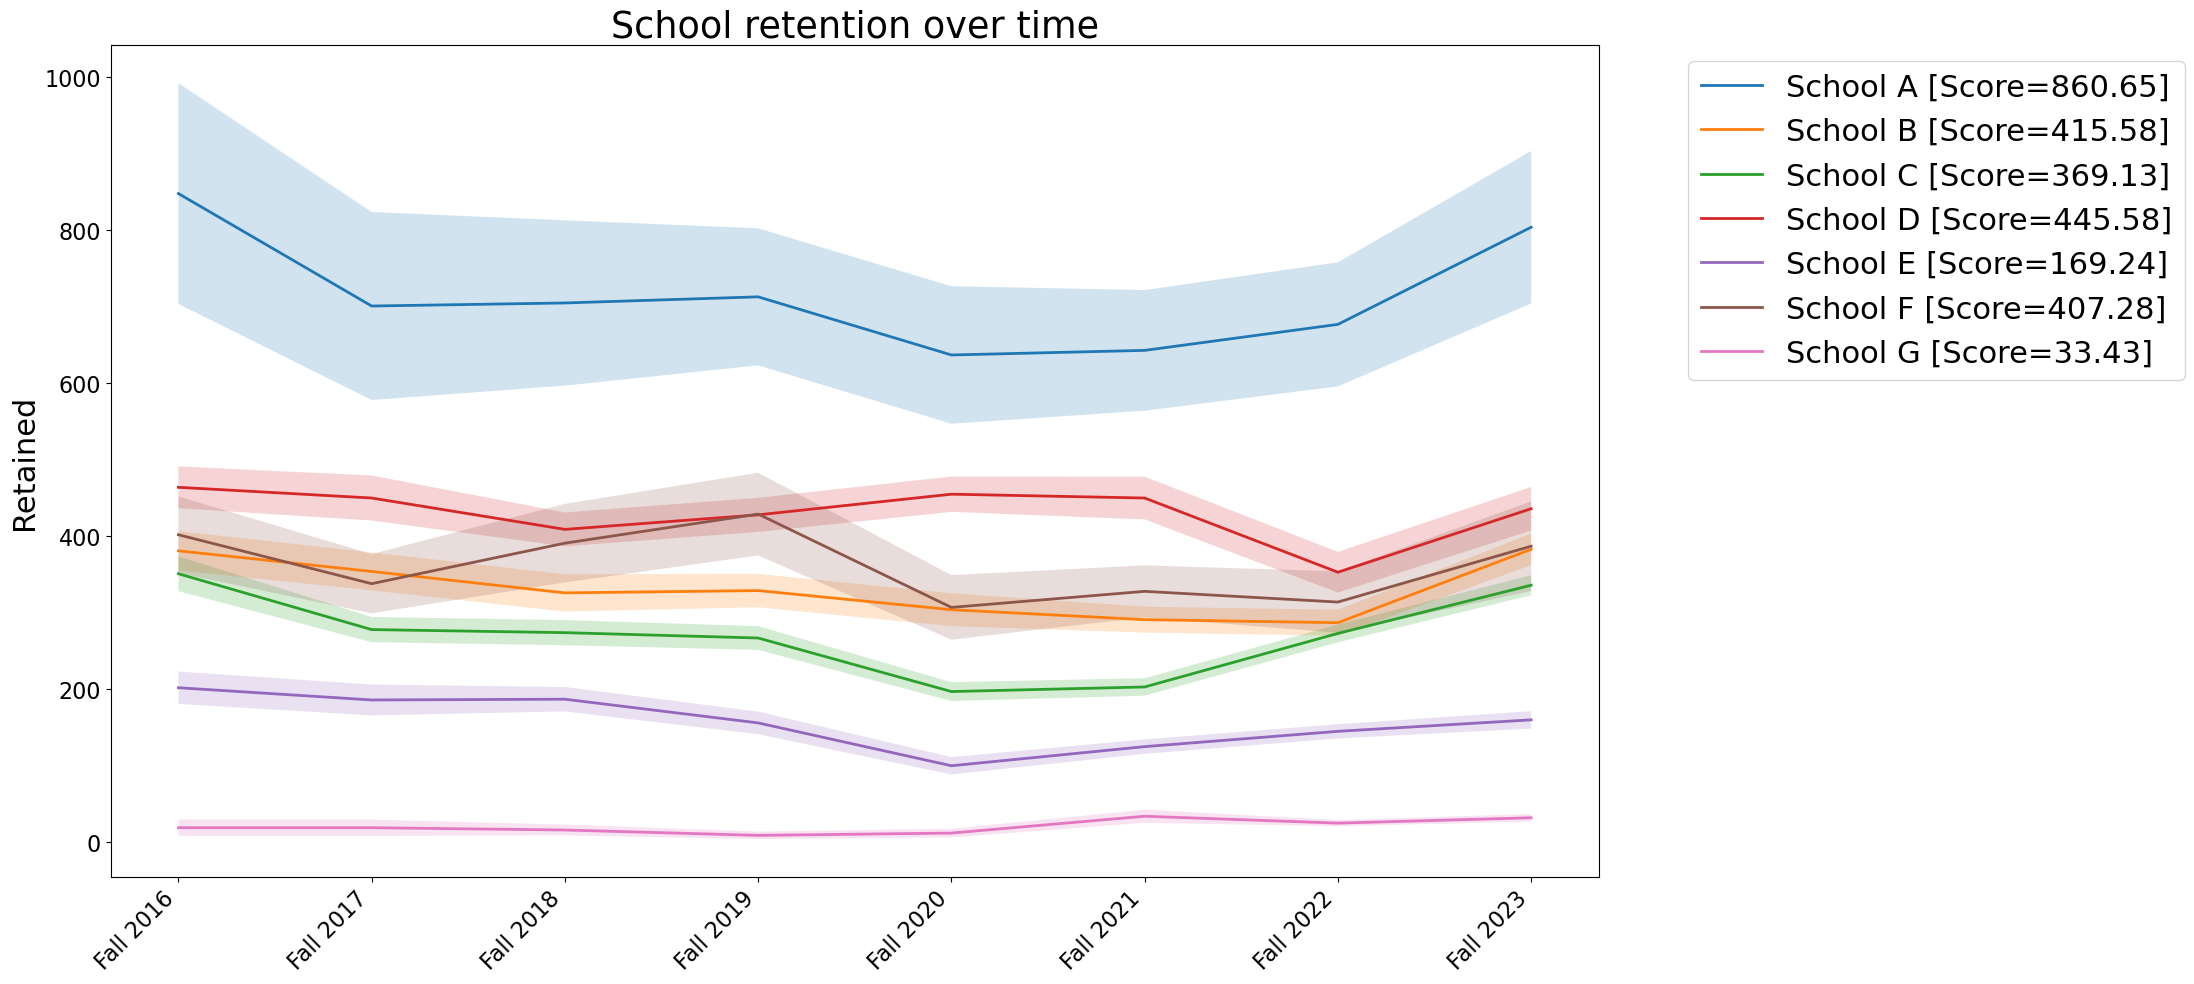

{'School': Empty DataFrame
 Columns: [School, missing data]
 Index: []}

In [75]:
target='Retained'
var_list = ['School']
school_trends_retained, school_missing_retained = retention_variation_curves(  df,
                                                                             var_list=var_list,
                                                                             target=target,
                                                                             lamda=lamda, 
                                                                             horizon=horizon)
school_missing_retained

In [76]:
school_trends_retained['School'].drop(columns=['score_label','x','y']).sort_values(by=['score'], ascending=False)

,School,score,average-retention-rate,retained this year
0,School A,860.65,694.8,804.0
3,School D,445.58,424.4,436.0
1,School B,415.58,318.8,383.0
5,School F,407.28,353.0,387.0
2,School C,369.13,255.2,336.0
4,School E,169.24,137.2,160.0
6,School G,33.43,22.4,32.0


In [78]:
school_trends_retained_rate['School'].drop(columns=['score_label','x','y']).sort_values(by=['score'], ascending=False)

,School,score,average-retention-rate,retained this year
6,School G,97.43,76.22,91.67
5,School F,94.78,83.46,90.51
0,School A,94.16,84.11,90.61
2,School C,92.34,86.48,90.87
4,School E,86.13,78.34,84.02
3,School D,83.91,88.76,85.48
1,School B,79.49,81.20,80.44


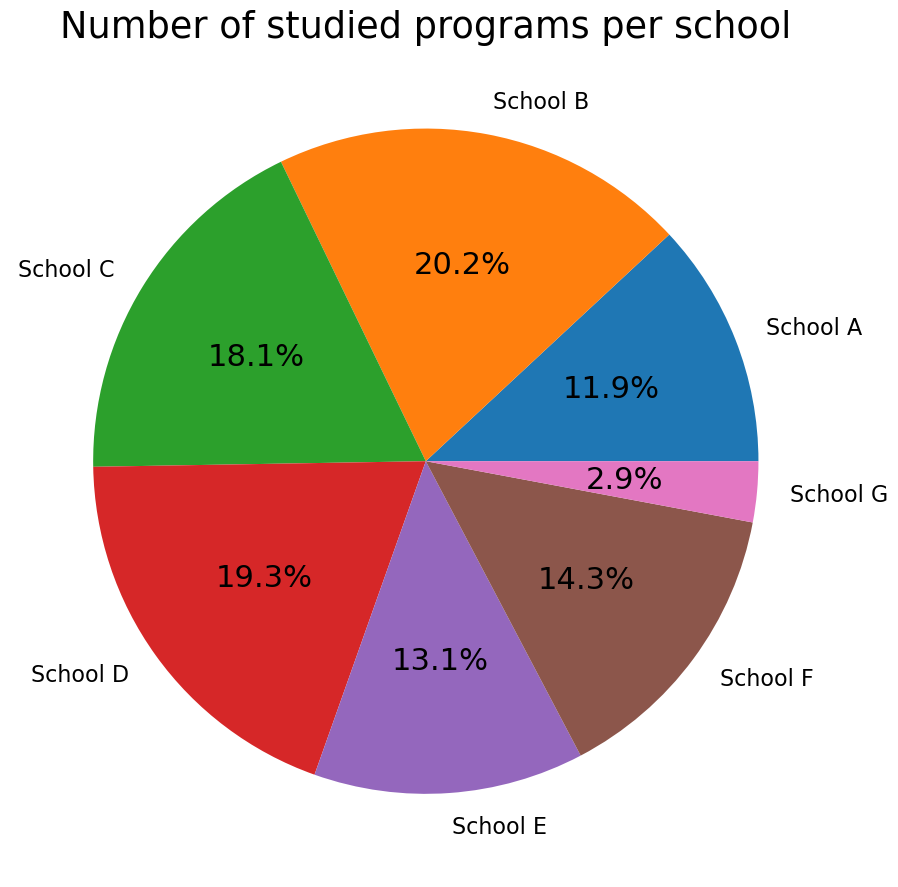

,School,Program,count(Program)
0,School A,ZVS,89
1,School B,XEM,151
2,School C,HIQ,135
3,School D,RFI,144
4,School E,EDB,98
5,School F,SYW,107
6,School G,IWU,22


In [99]:
schools_prog_df1 = sqldf(f"SELECT School, Program, count(Program) \
                 FROM df \
                 GROUP BY School \
                 ")

# define the experiment 
experiemnt=f'PartA_programs_per_school'

# visualize the plots 
fig = plt.figure(figsize=(19.20,10.80))
plt.pie(schools_prog_df1['count(Program)'], labels=schools_prog_df1['School'], autopct='%1.1f%%')
plt.title('Number of studied programs per school')
output_filename=f'outputs/{experiemnt}.svg'
fig.savefig(output_filename, format='svg', dpi=1200)
plt.show()

schools_prog_df1

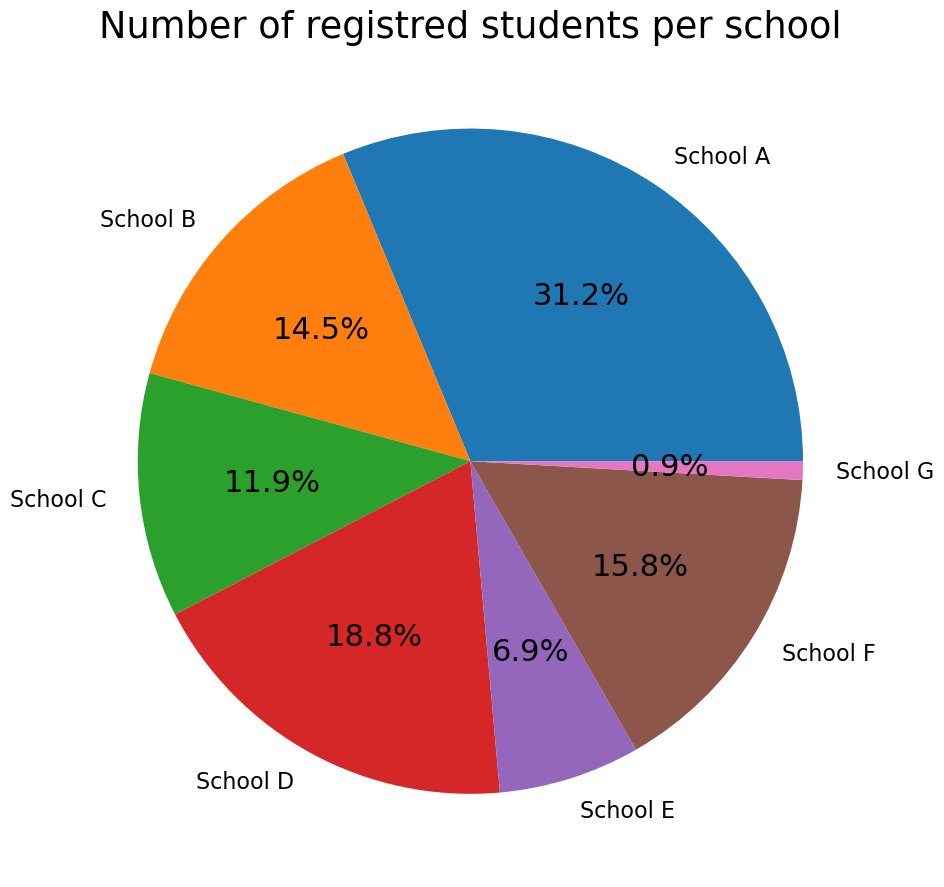

In [37]:
# Show the labels distribution
stdents_df = df.groupby(['School'], as_index=False)[target].sum()
# plot the Pie chart

# define the experiment 
experiemnt=f'PartA_registred_stuents_per_school'

# visualize the plots 
fig = plt.figure(figsize=(19.20,10.80))
plt.pie(stdents_df['Retained'], labels=stdents_df['School'], autopct='%1.1f%%')
plt.title('Number of registred students per school')
output_filename=f'outputs/{experiemnt}.svg'
fig.savefig(output_filename, format='svg', dpi=1200)
plt.show()

## 2. Retention variation between domestic and international students 

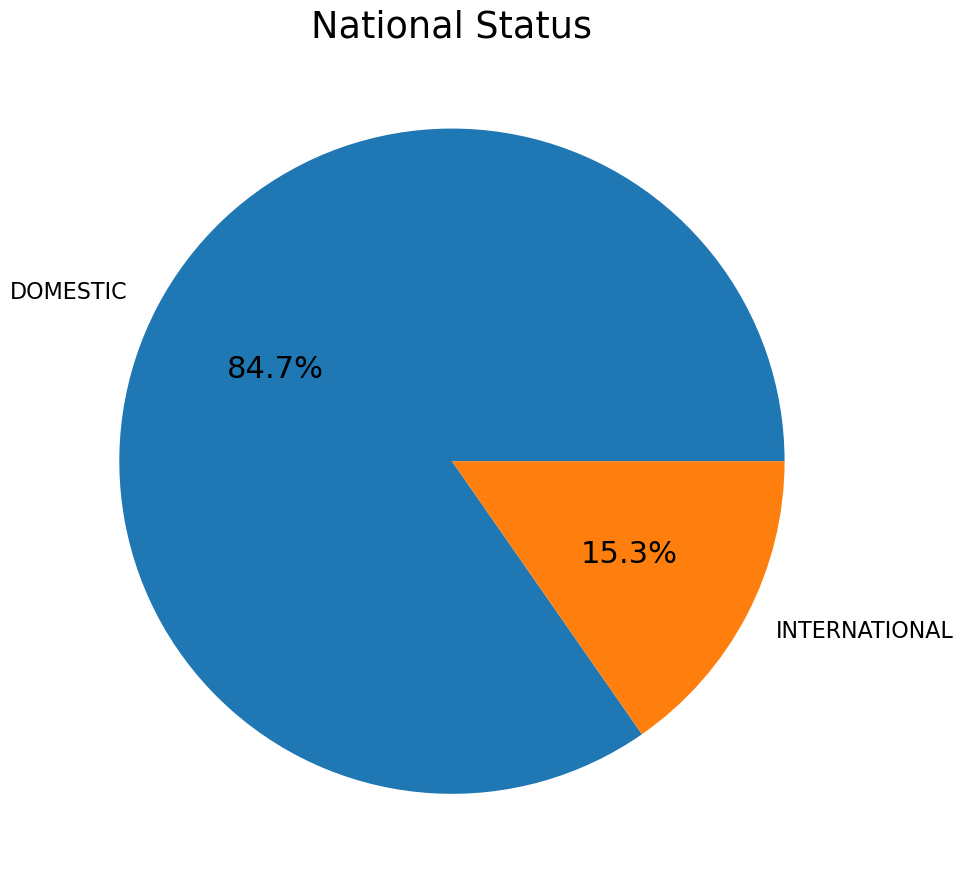

In [114]:
target='Retained'
# Show the labels distribution
stdents_df = df.groupby(['NationalStatus'], as_index=False)[target].sum()

stdents_df

# plot the Pie chart
fig = plt.figure(figsize=(19.20,10.80))
plt.pie(stdents_df[target], labels=stdents_df['NationalStatus'], autopct='%1.1f%%')
plt.title('National Status')
experiemnt=f'PartA_National_Status_sudents'
output_filename=f'outputs/{experiemnt}.svg'
fig.savefig(output_filename, format='svg', dpi=1200)
plt.show()

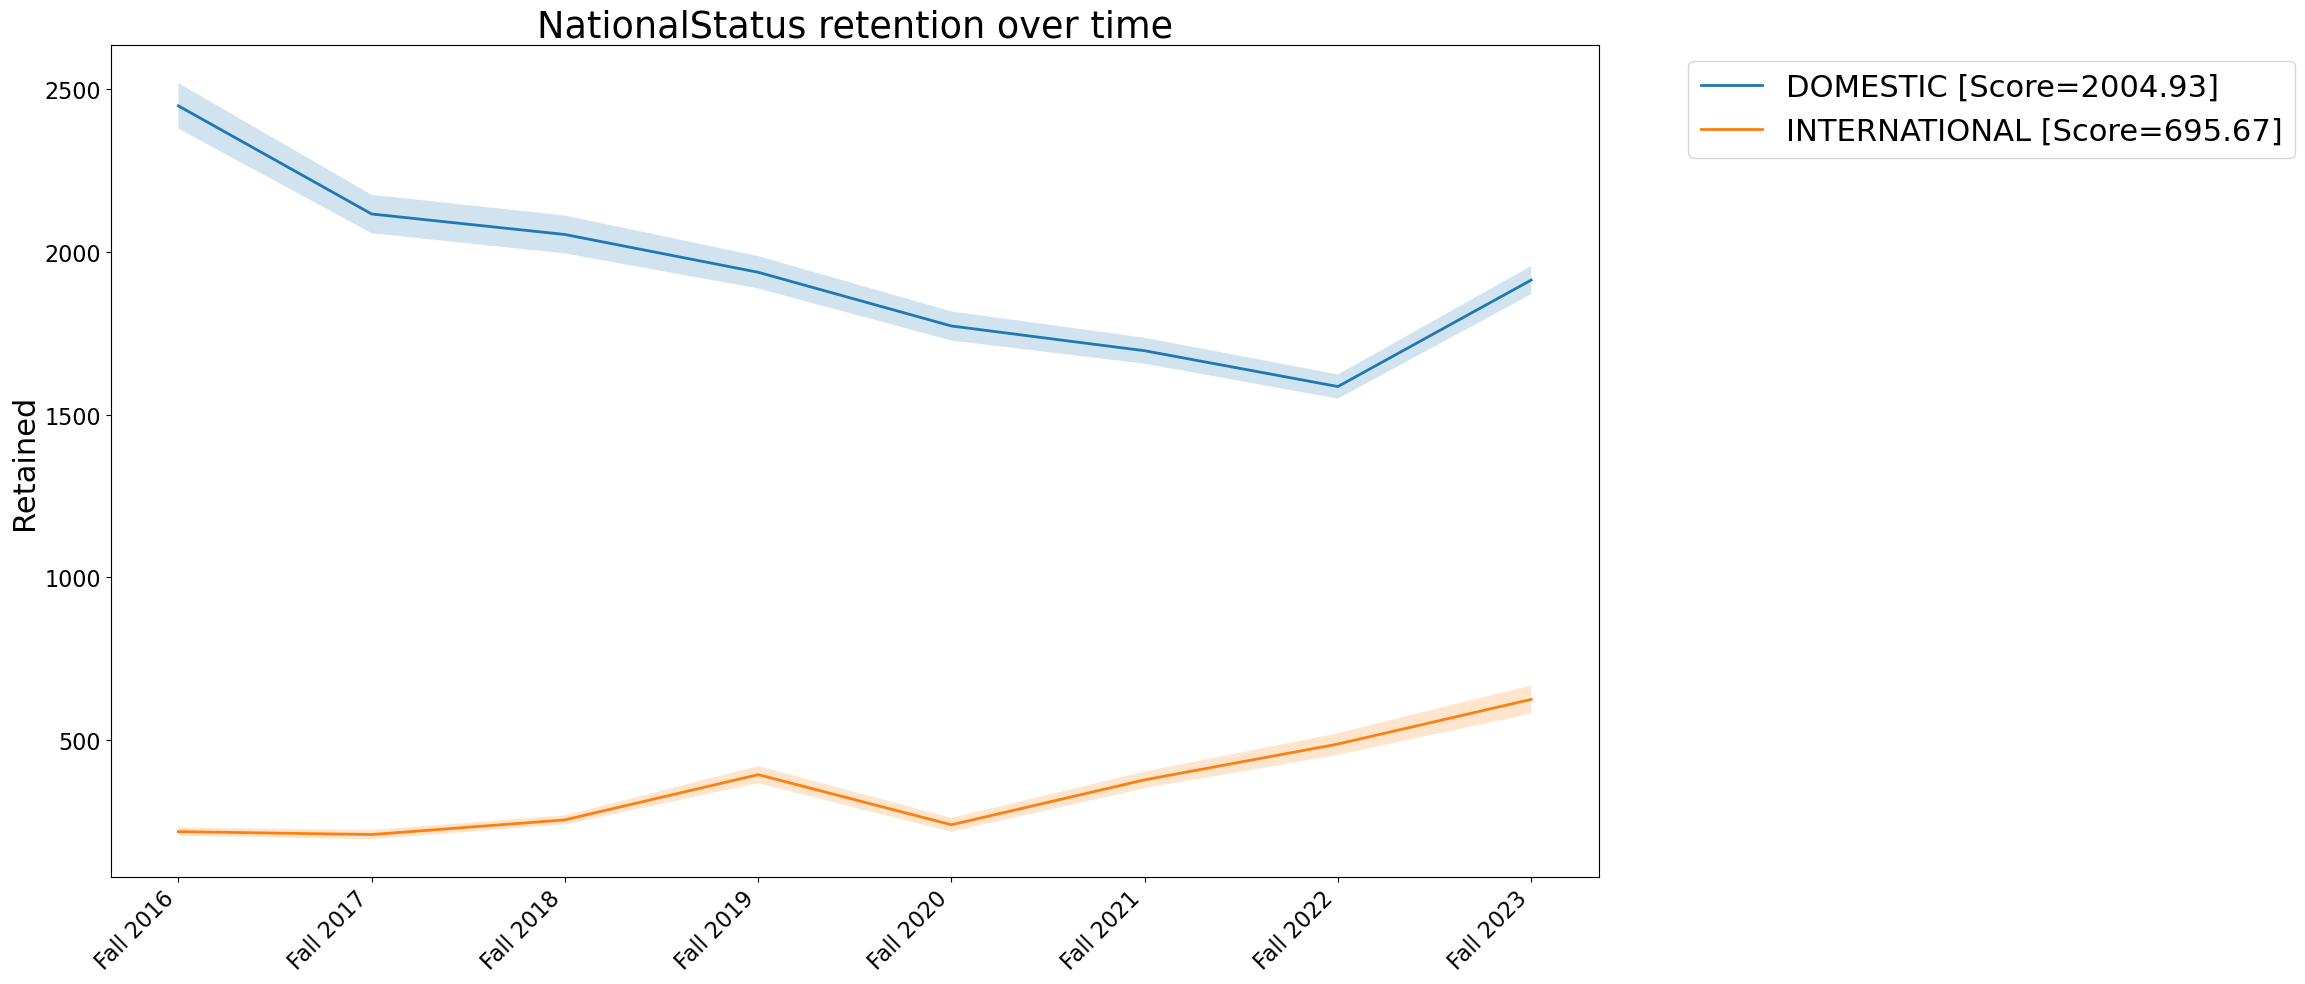

{'NationalStatus': Empty DataFrame
 Columns: [NationalStatus, missing data]
 Index: []}

In [115]:
var_list = [ 'NationalStatus']
sudents_trends_retained, sudents_missing_retained = retention_variation_curves(  df,
                                                                 var_list=var_list,
                                                                 target=target,
                                                                 lamda=lamda, 
                                                                 horizon=horizon)
sudents_missing_retained

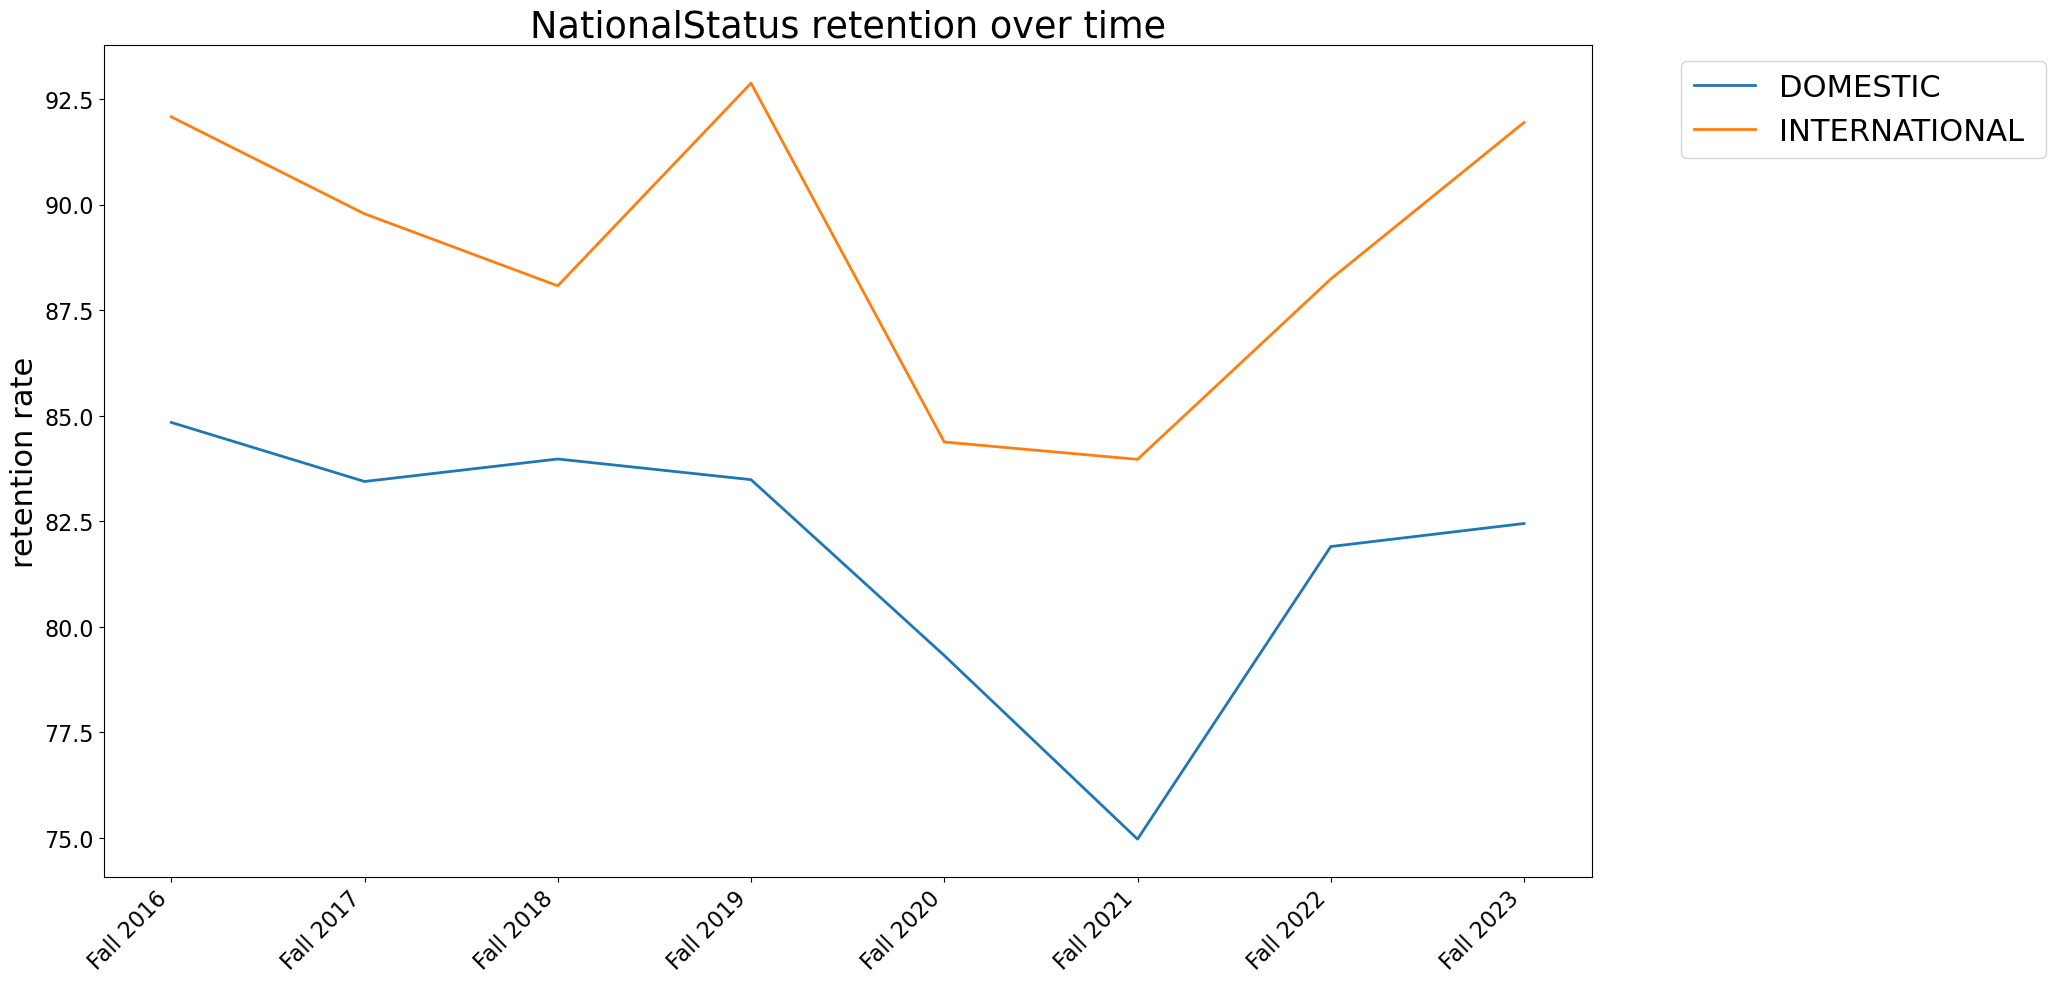

{'NationalStatus': Empty DataFrame
 Columns: [NationalStatus, missing data]
 Index: []}

In [118]:
var_list = ['NationalStatus']
sudents_trends_retained_rate, sudents_missing_retained_rate = retention_variation_curves(  df,
                                                                 var_list=var_list,
                                                                 target='retention rate',
                                                                 lamda=lamda, 
                                                                 horizon=horizon)
sudents_missing_retained_rate

## 3. missing data

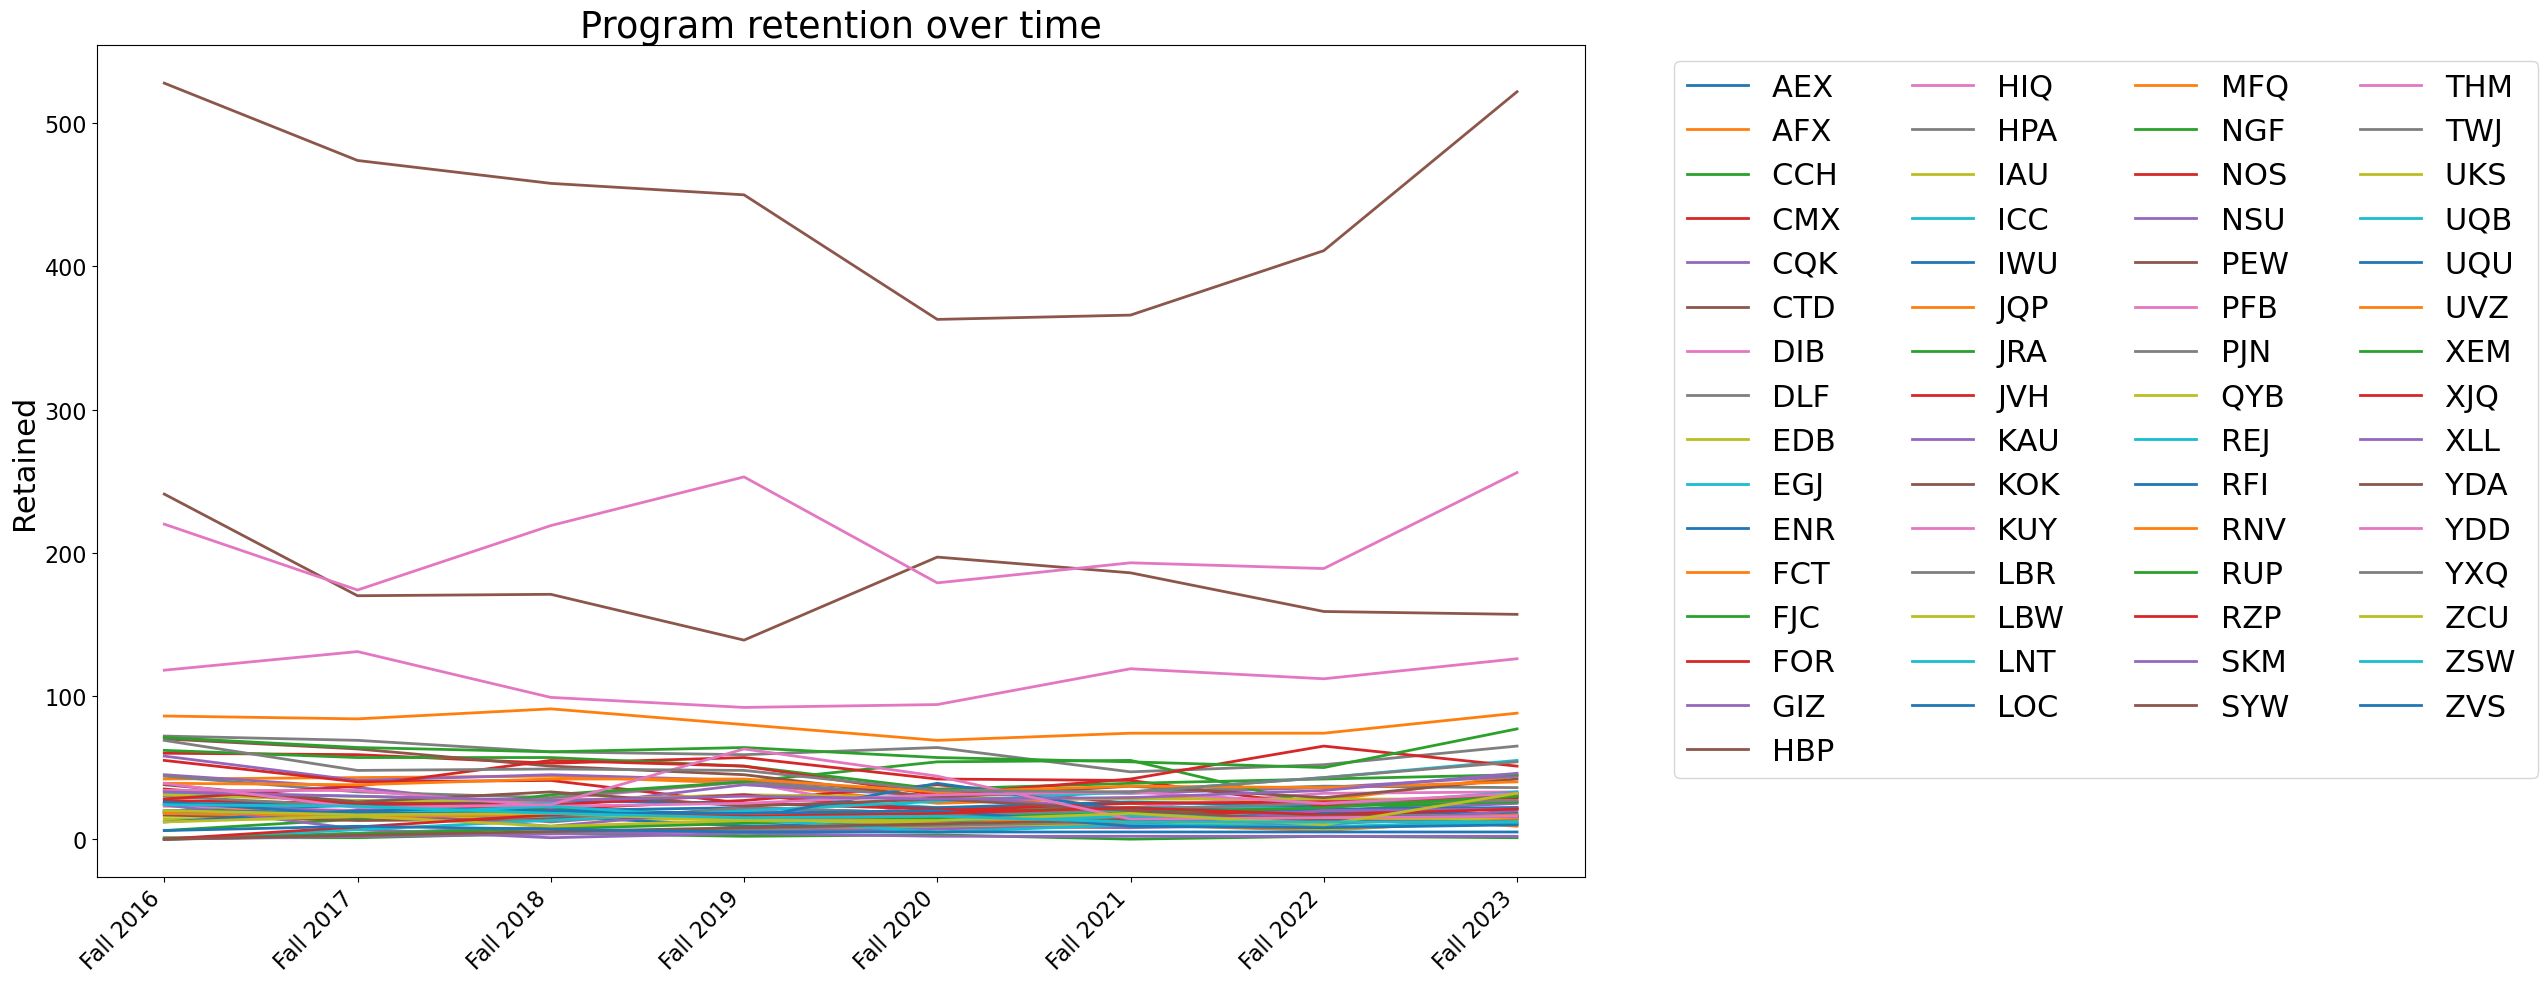

{'Program':    Program                                                        missing data
 0      ICC             [Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020]
 1      LBW                                              [Fall 2022, Fall 2023]
 2      LNT                                              [Fall 2022, Fall 2023]
 3      NSU                                   [Fall 2021, Fall 2022, Fall 2023]
 4      PJN  [Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021]
 5      QYB             [Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020]
 6      REJ             [Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020]
 7      RUP  [Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021]
 8      SKM             [Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020]
 9      TWJ             [Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020]
 10     XJQ                                              [Fall 2016, Fall 2017]
 11     YDA  [Fall 2016, Fall

In [120]:
target='Retained'
var_list = ['Program']
program_trends_retained, program_missing_retained = retention_variation_curves(  df,
                                                                             var_list=var_list,
                                                                             target=target,
                                                                             lamda=lamda, 
                                                                             horizon=horizon)
program_missing_retained

In [122]:
pd.set_option("max_colwidth", None)
program_missing_retained['Program']

,Program,missing data
0,ICC,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020]"
1,LBW,"[Fall 2022, Fall 2023]"
2,LNT,"[Fall 2022, Fall 2023]"
3,NSU,"[Fall 2021, Fall 2022, Fall 2023]"
4,PJN,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021]"
5,QYB,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020]"
6,REJ,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020]"
7,RUP,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021]"
8,SKM,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020]"
9,TWJ,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020]"


# TRENDS of the pair(program, national status)

### 1. prepare the pair dataframes

In [143]:
target='sum_Retained'
var_list=['School','Program','NationalStatus']

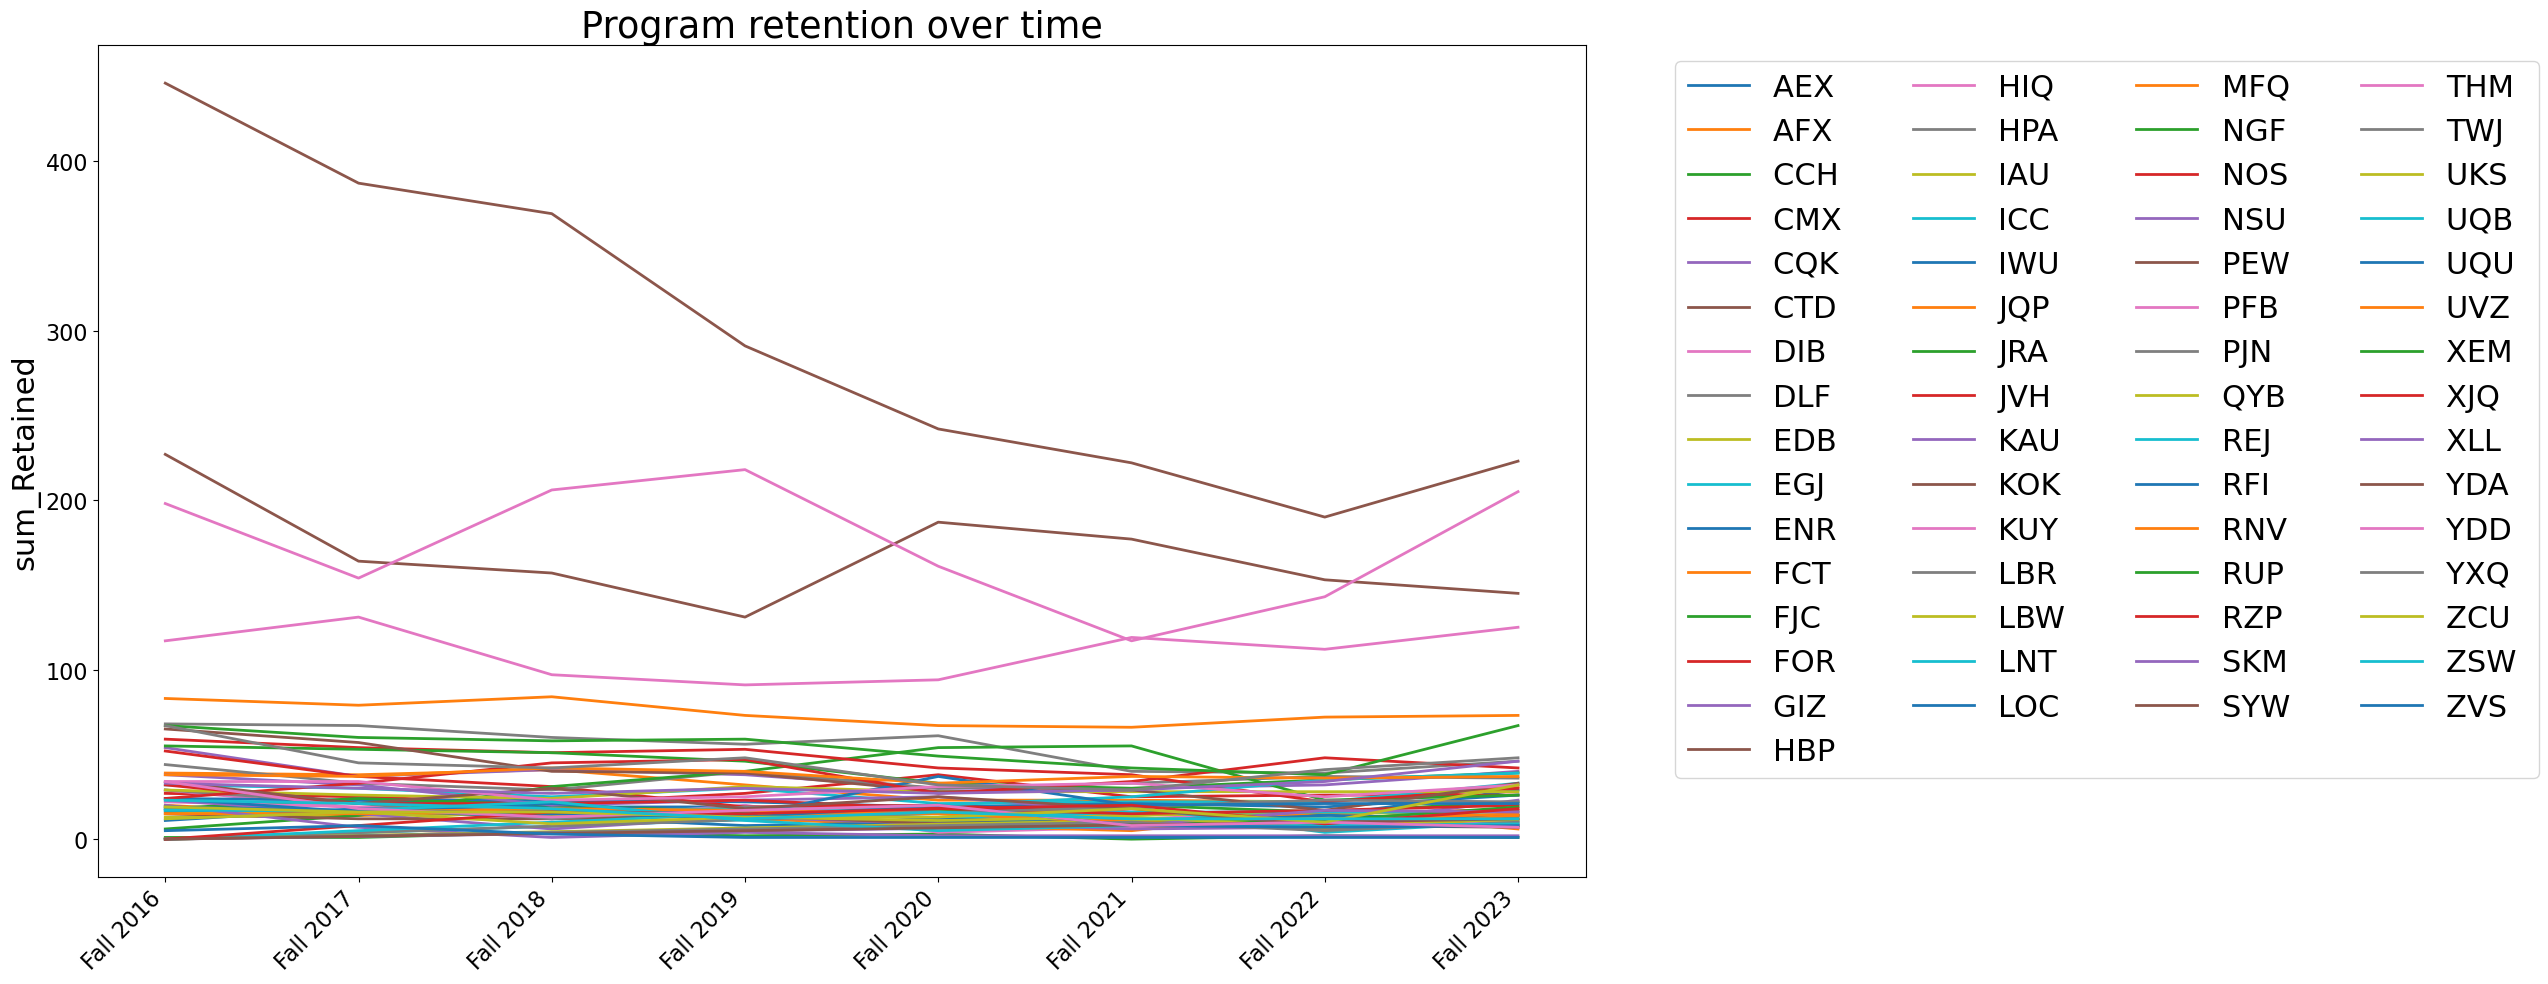

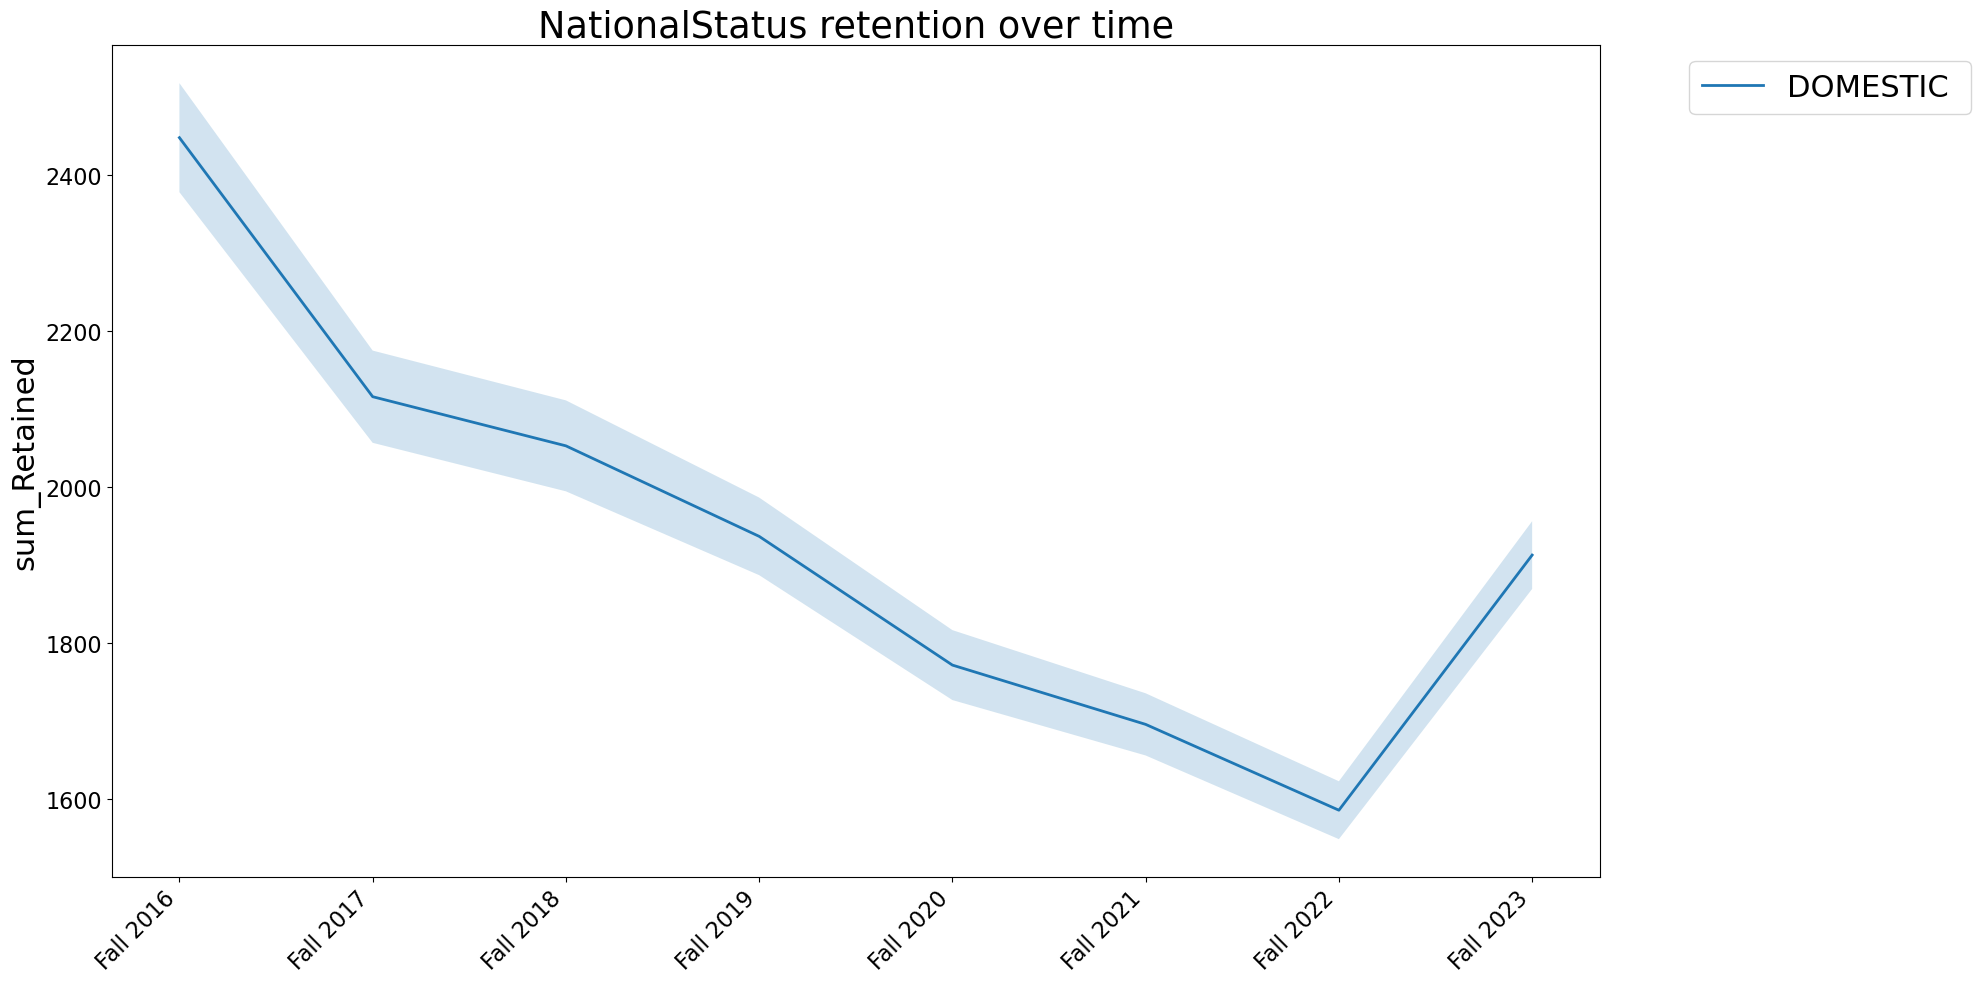

In [145]:
# SQl query: considering the DOMESTIC student
pair_PN_df1 = sqldf(f"SELECT AdmitTerm, Program , NationalStatus, SUM(Enrolled) AS sum_Enrolled, SUM(Retained) AS sum_Retained \
                 FROM df \
                 WHERE  NationalStatus='DOMESTIC'\
                 GROUP BY AdmitTerm, Program \
                 ORDER BY AdmitTerm \
                 ")
PN_trends_retained1, PN_missing_retained1 = retention_variation_curves(  pair_PN_df1,
                                                                         var_list=var_list,
                                                                         target=target,
                                                                         lamda=lamda, 
                                                                         horizon=horizon)

In [146]:
PN_trends_retained1['Program']['NationalStatus']='DOMESTIC'
PN_trends_retained1['Program']


,Program,score,average-retention-rate,retained this year,score_label,x,y,NationalStatus
15,HBP,222.38,233.60,223.0,Score=222.38,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021, Fall 2022, Fall 2023]","[446.0, 387.0, 369.0, 291.0, 242.0, 222.0, 190.0, 223.0]",DOMESTIC
36,PFB,222.23,168.80,205.0,Score=222.23,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021, Fall 2022, Fall 2023]","[198.0, 154.0, 206.0, 218.0, 161.0, 117.0, 143.0, 205.0]",DOMESTIC
5,CTD,135.01,158.60,145.0,Score=135.01,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021, Fall 2022, Fall 2023]","[227.0, 164.0, 157.0, 131.0, 187.0, 177.0, 153.0, 145.0]",DOMESTIC
26,KUY,131.64,108.20,125.0,Score=131.64,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021, Fall 2022, Fall 2023]","[117.0, 131.0, 97.0, 91.0, 94.0, 119.0, 112.0, 125.0]",DOMESTIC
21,JQP,74.36,70.20,73.0,Score=74.36,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021, Fall 2022, Fall 2023]","[83.0, 79.0, 84.0, 73.0, 67.0, 66.0, 72.0, 73.0]",DOMESTIC
52,XEM,73.41,51.00,67.0,Score=73.41,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021, Fall 2022, Fall 2023]","[67.0, 60.0, 58.0, 59.0, 49.0, 42.0, 38.0, 67.0]",DOMESTIC
57,YXQ,51.55,39.60,48.0,Score=51.55,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021, Fall 2022, Fall 2023]","[67.0, 45.0, 42.0, 48.0, 32.0, 29.0, 41.0, 48.0]",DOMESTIC
54,XLL,51.25,33.20,46.0,Score=51.25,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021, Fall 2022, Fall 2023]","[33.0, 30.0, 27.0, 30.0, 27.0, 29.0, 34.0, 46.0]",DOMESTIC
7,DLF,45.65,48.40,46.0,Score=45.65,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021, Fall 2022, Fall 2023]","[68.0, 67.0, 60.0, 56.0, 61.0, 40.0, 39.0, 46.0]",DOMESTIC
4,CQK,43.10,34.00,40.0,Score=43.10,"[Fall 2016, Fall 2017, Fall 2018, Fall 2019, Fall 2020, Fall 2021, Fall 2022, Fall 2023]","[54.0, 37.0, 41.0, 38.0, 30.0, 30.0, 32.0, 40.0]",DOMESTIC


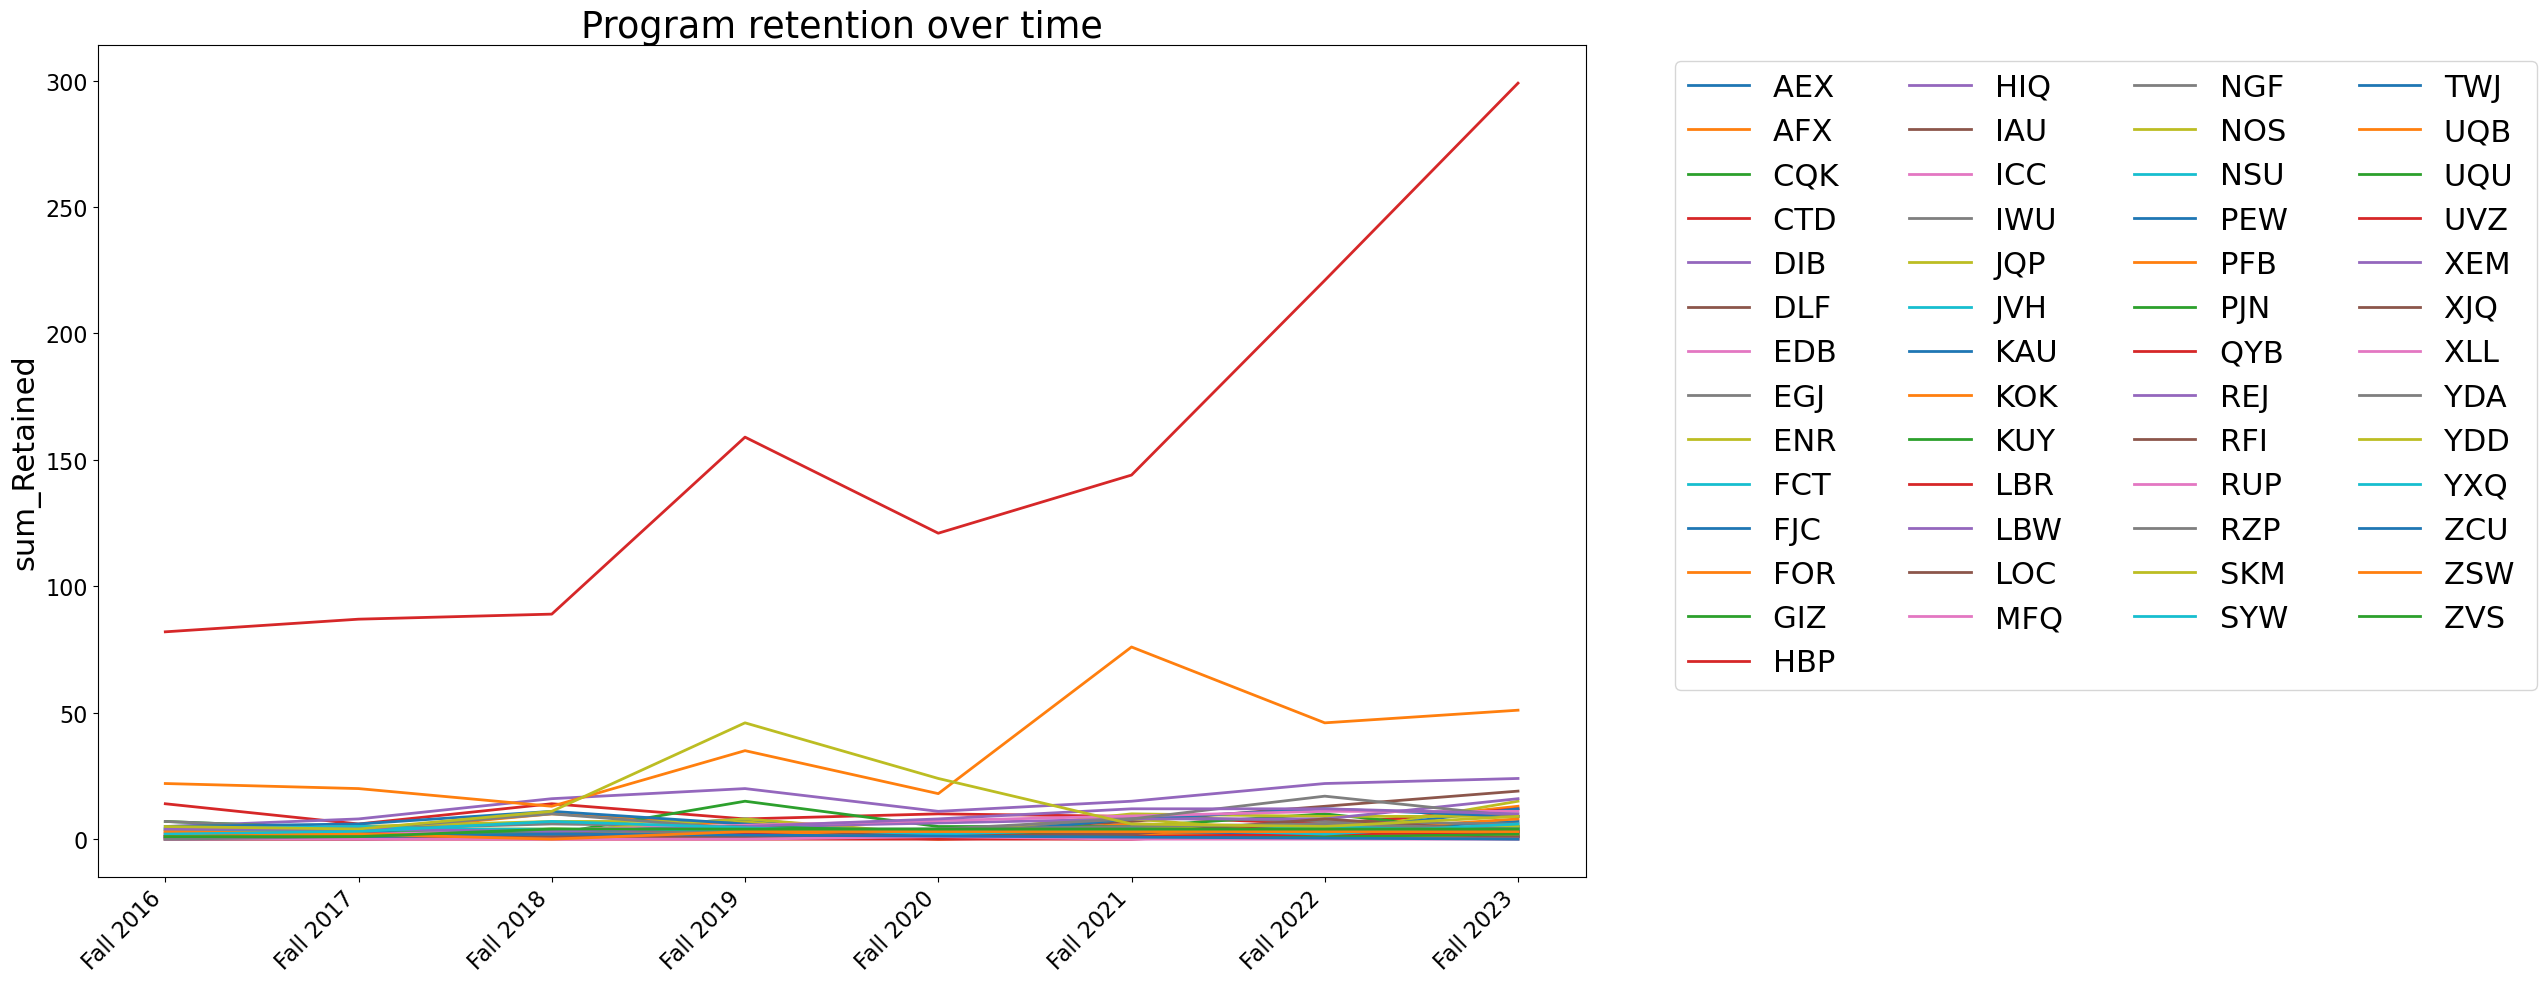

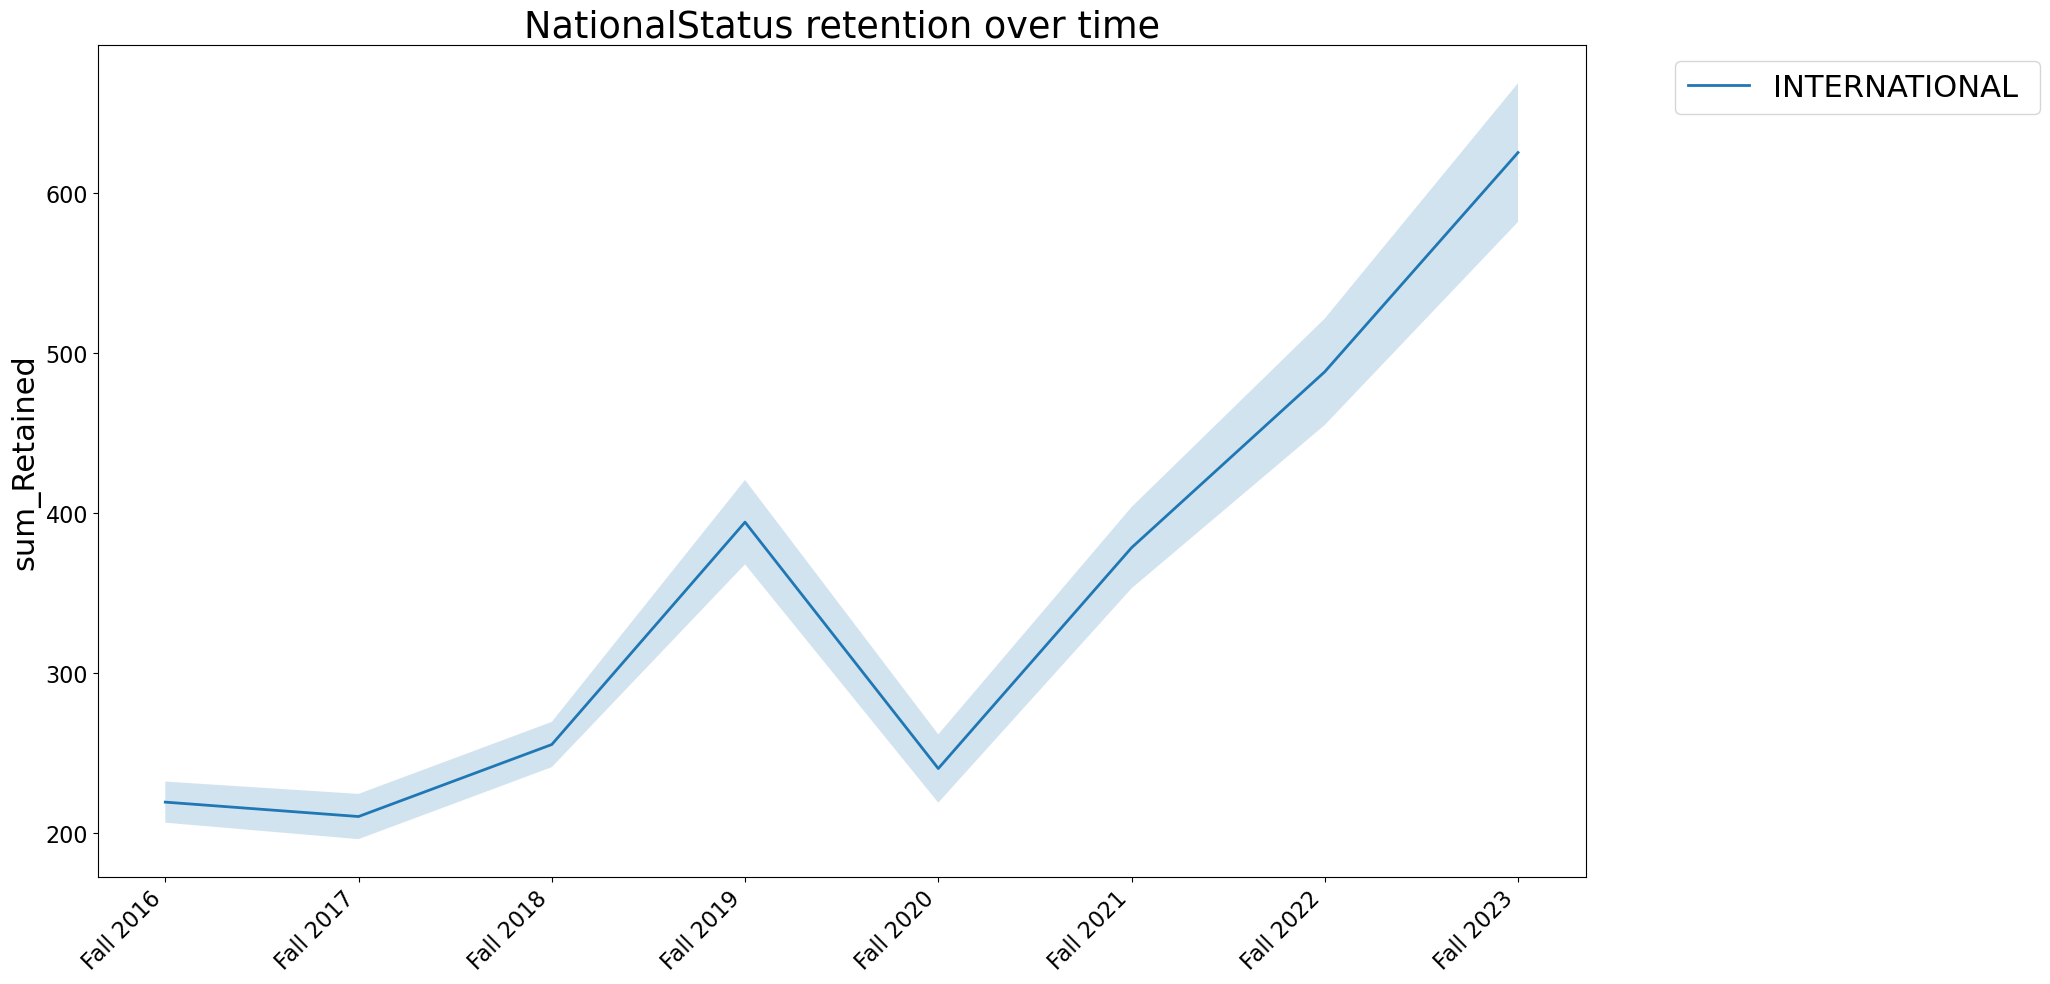

In [148]:
# SQl query: considering the DOMESTIC student
pair_PN_df2 = sqldf(f"SELECT AdmitTerm, Program , NationalStatus, SUM(Enrolled) AS sum_Enrolled, SUM(Retained) AS sum_Retained \
                 FROM df \
                 WHERE  NationalStatus='INTERNATIONAL' \
                 GROUP BY AdmitTerm, Program \
                 ORDER BY AdmitTerm \
                 ")
PN_trends_retained2, PN_missing_retained2 = retention_variation_curves(  pair_PN_df2,
                                                                         var_list=var_list,
                                                                         target=target,
                                                                         lamda=lamda, 
                                                                         horizon=horizon)

In [149]:
PN_trends_retained2['Program']['NationalStatus']='INTERNATIONAL'
# PN_trends_retained2['Program']

In [180]:
# Concatenation 
PN_trends_retained = pd.concat([PN_trends_retained1['Program'], PN_trends_retained2['Program']]).sort_values(by=['score'], ascending=False)

### 2. rank the pair(program, national status)

 show the TOP20 and WORST20 Program: 

 show the TOP20 and WORST20 : 



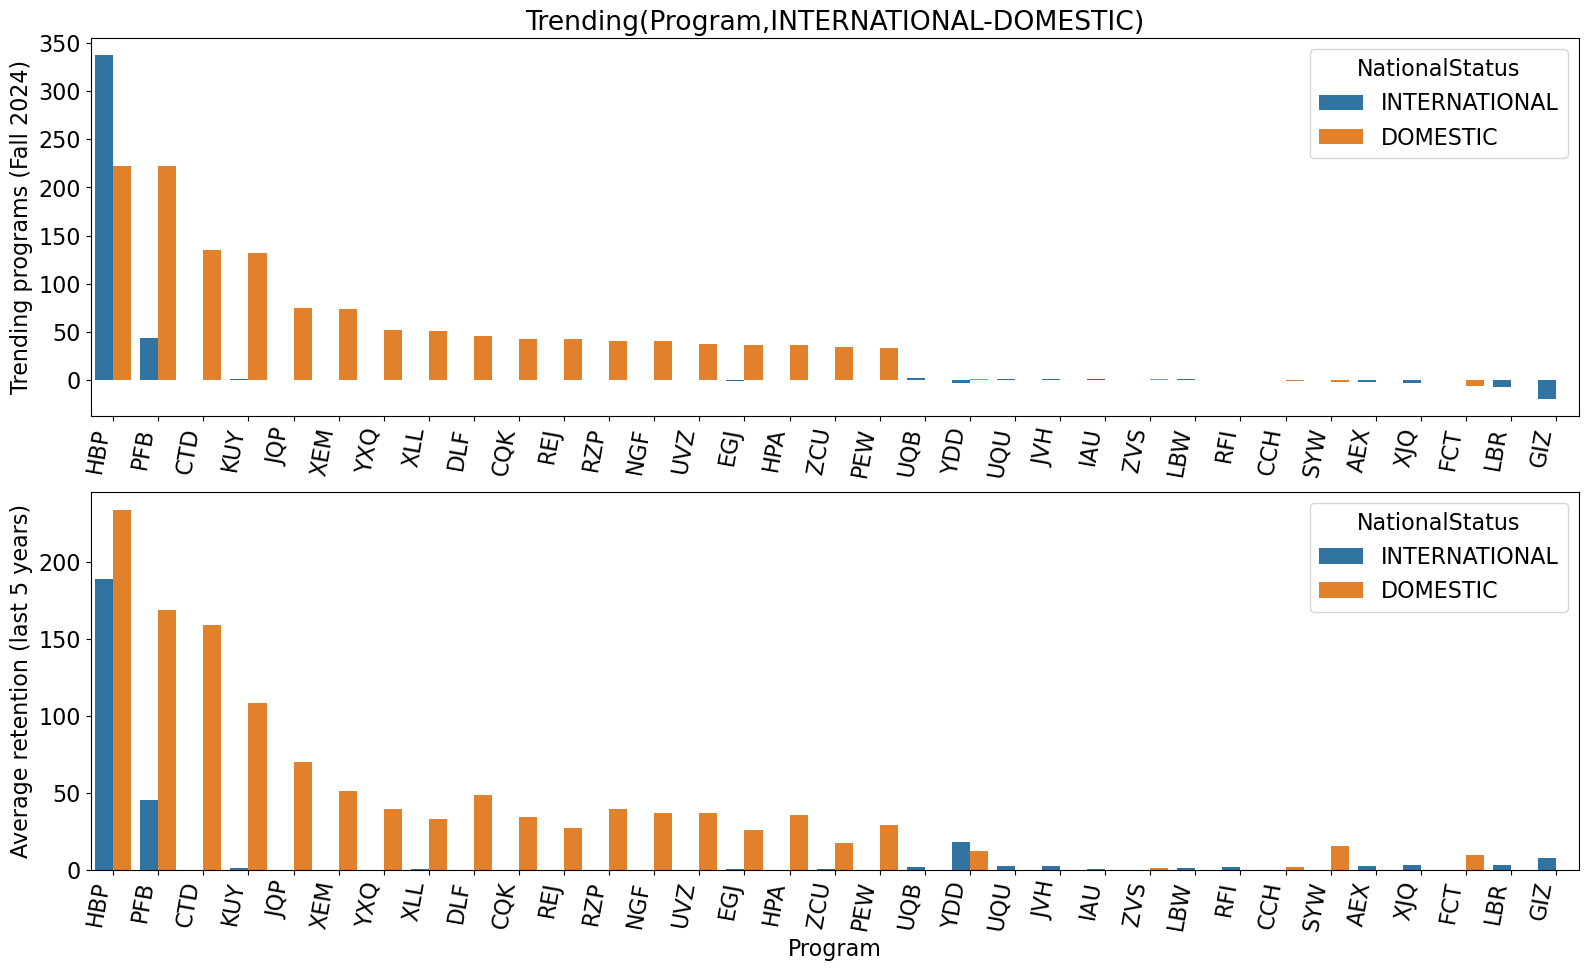

In [184]:
PN_trends_retained_topN = PN_variabtion_curves_topN(PN_trends_retained, hue='NationalStatus', N=20)

In [186]:
PN_trends_retained_topN.sort_values(by=['score'], ascending=True)

,Program,NationalStatus,score,average-retention-rate
113,GIZ,INTERNATIONAL,-19.56,7.4
112,LBR,INTERNATIONAL,-7.44,2.8
111,FCT,DOMESTIC,-6.04,9.4
110,YDD,INTERNATIONAL,-3.08,18.0
109,XJQ,INTERNATIONAL,-2.62,3.1
108,AEX,INTERNATIONAL,-2.00,2.6
107,SYW,DOMESTIC,-2.00,15.2
106,CCH,DOMESTIC,-1.00,1.6
105,EGJ,INTERNATIONAL,-0.50,0.8
104,ZCU,INTERNATIONAL,-0.26,0.8


### 3. rank the  programs for  DOMESTIC students 

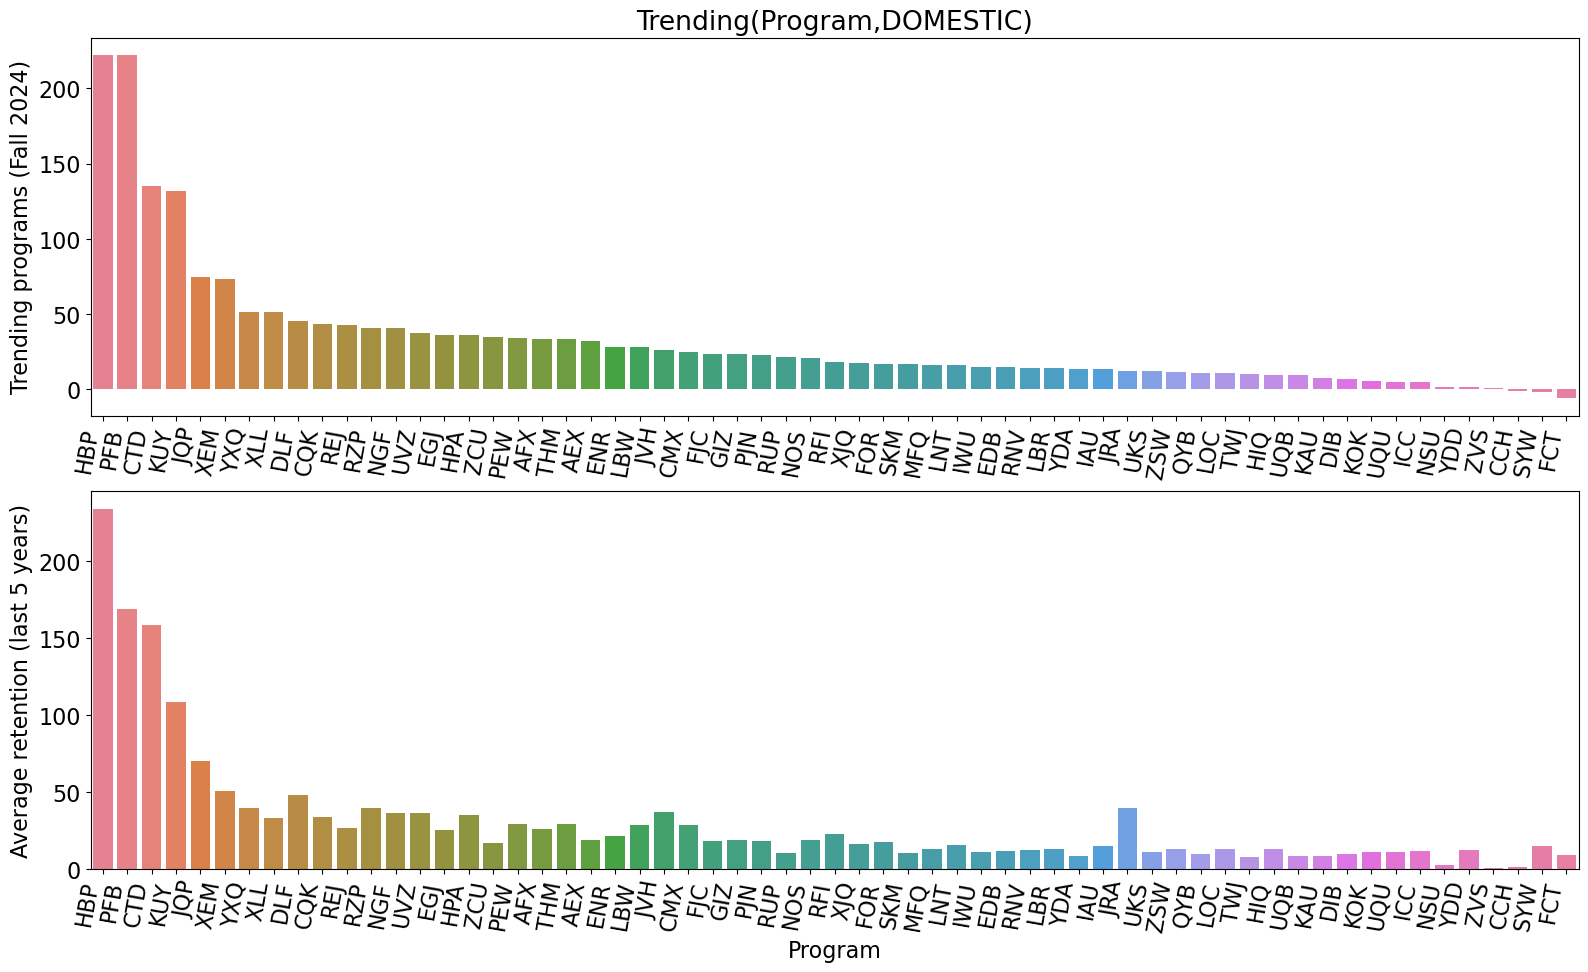

,Program,NationalStatus,score,average-retention-rate
0,HBP,DOMESTIC,222.38,233.6
1,PFB,DOMESTIC,222.23,168.8
2,CTD,DOMESTIC,135.01,158.6
3,KUY,DOMESTIC,131.64,108.2
4,JQP,DOMESTIC,74.36,70.2
...,...,...,...,...
56,YDD,DOMESTIC,1.60,12.4
57,ZVS,DOMESTIC,1.00,1.0
58,CCH,DOMESTIC,-1.00,1.6
59,SYW,DOMESTIC,-2.00,15.2


In [171]:
# plot the NationalStatus in one or seperate plots 
nationalStatus = 'DOMESTIC'
PN_trends_retained_dometic=PN_trends_retained[PN_trends_retained['NationalStatus']== nationalStatus]
PN_variabtion_curves_topN(PN_trends_retained_dometic, hue='Program', N=-1)

### 4. rank the  programs for  INTERNATIONAL students 

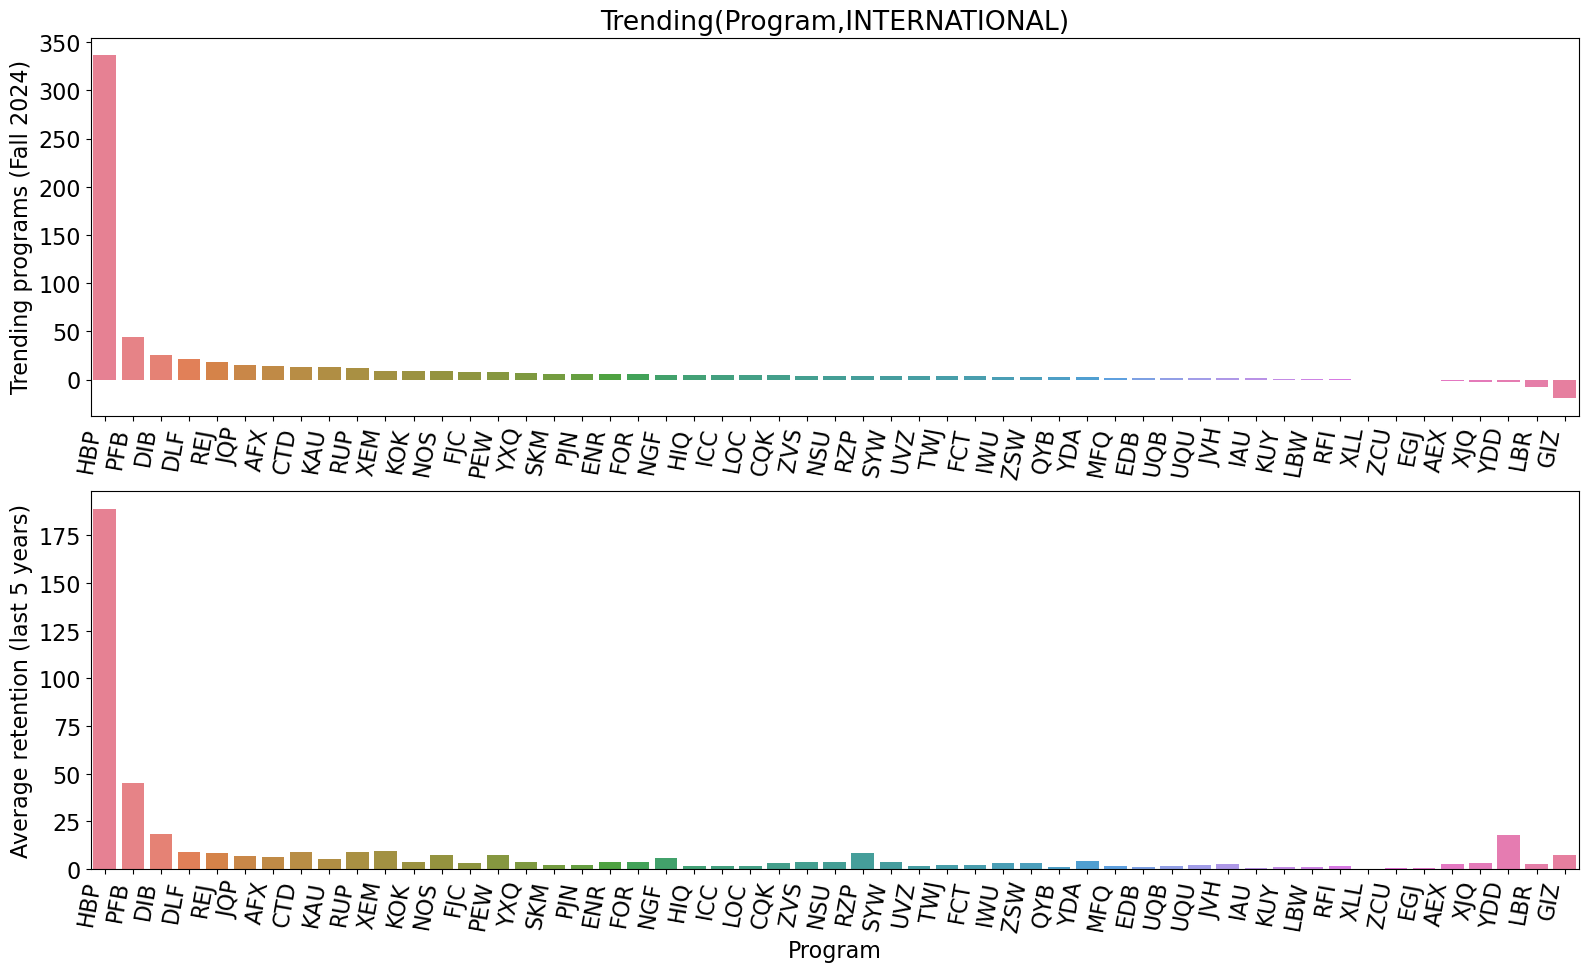

,Program,NationalStatus,score,average-retention-rate
0,HBP,INTERNATIONAL,337.00,188.80
1,PFB,INTERNATIONAL,43.91,45.20
2,DIB,INTERNATIONAL,25.77,18.40
3,DLF,INTERNATIONAL,21.68,9.00
4,REJ,INTERNATIONAL,18.11,8.64
...,...,...,...,...
48,AEX,INTERNATIONAL,-2.00,2.60
49,XJQ,INTERNATIONAL,-2.62,3.10
50,YDD,INTERNATIONAL,-3.08,18.00
51,LBR,INTERNATIONAL,-7.44,2.80


In [172]:
# plot the NationalStatus in one or seperate plots 
nationalStatus = 'INTERNATIONAL'
PN_trends_retained_international=PN_trends_retained[PN_trends_retained['NationalStatus']== nationalStatus]
PN_variabtion_curves_topN(PN_trends_retained_international, hue='Program', N=-1)

# II. Use case

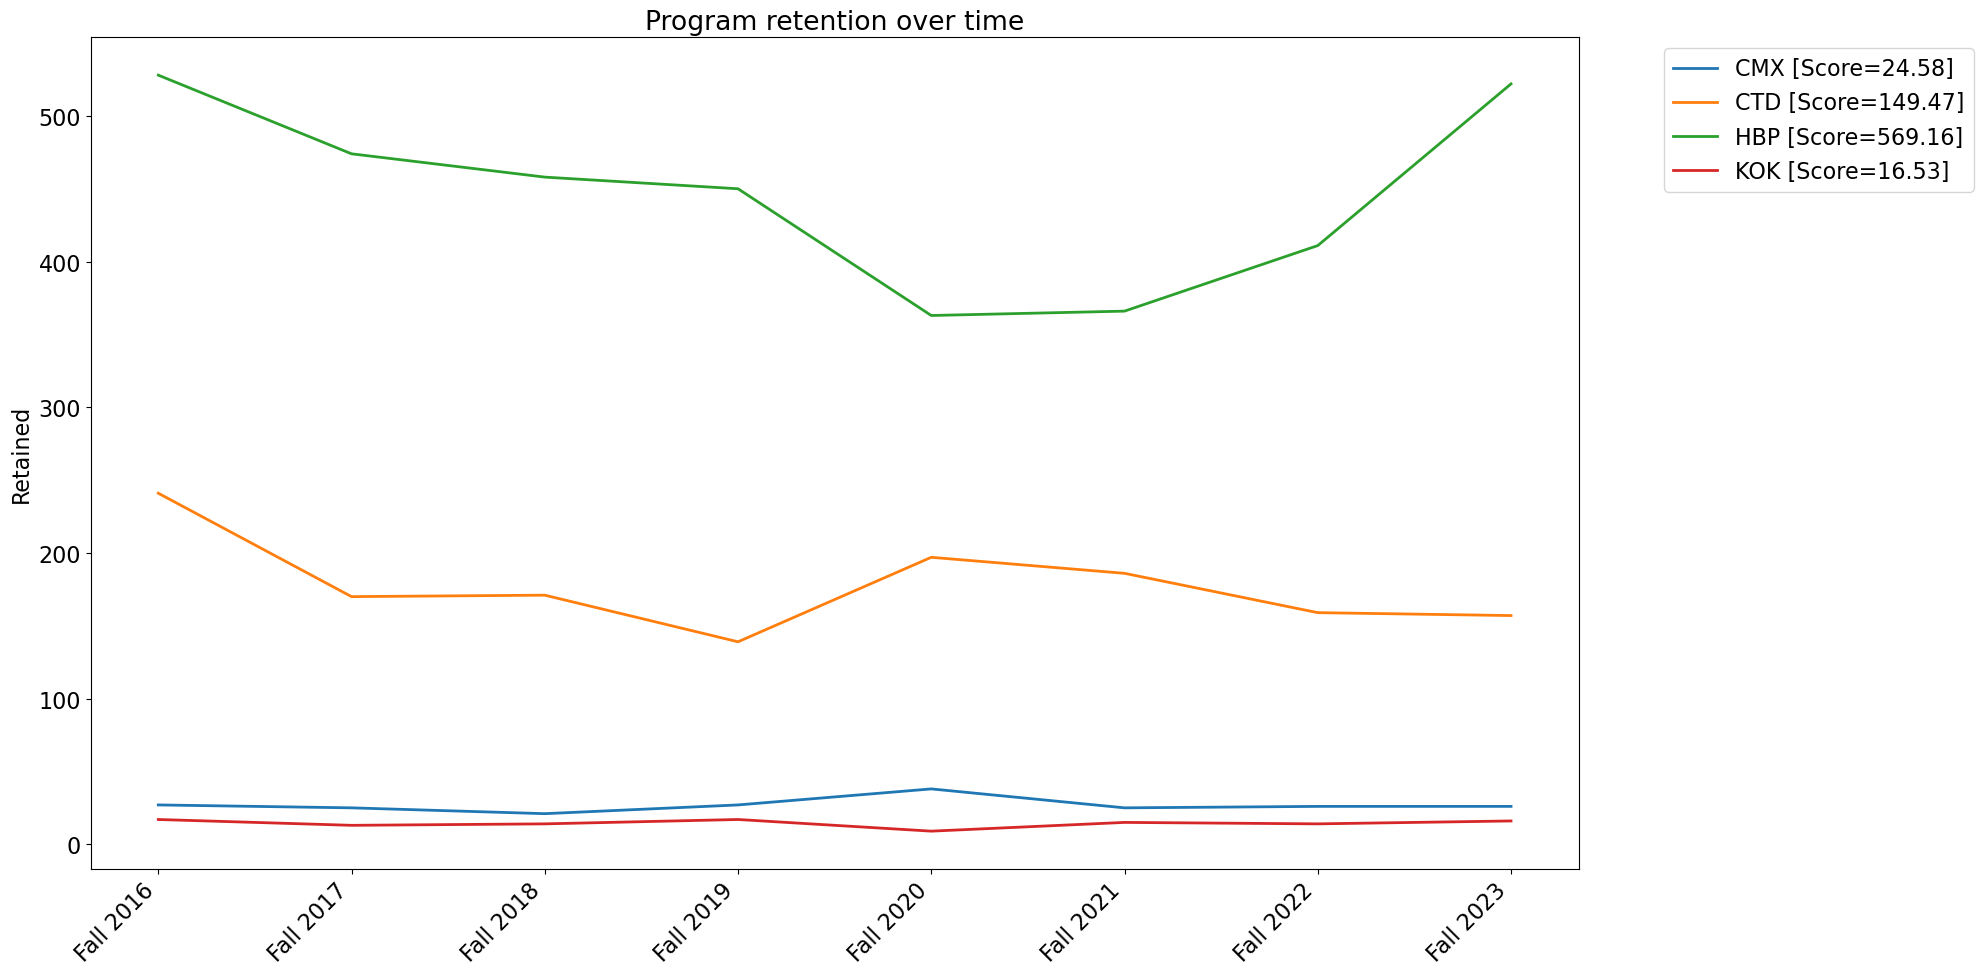

In [193]:
target='Retained'
var_list= ['Program']
program_list=['HBP', 'CTD', 'CMX', 'KOK']
df2=df.loc[df['Program'].isin(program_list)]
trends_retained_df2, missing_retained_df2 = retention_variation_curves(  df2,
                                                                         var_list=var_list,
                                                                         target=target,
                                                                         lamda=lamda, 
                                                                         horizon=horizon)

In [199]:
top_programs_list=['HBP', 'PFB', 'KUY', 'JQP', 'XEM', 'YXQ']
worst_programs_list=['SYW', 'AEX', 'XQJ', 'FCT', 'LBR', 'GIZ']

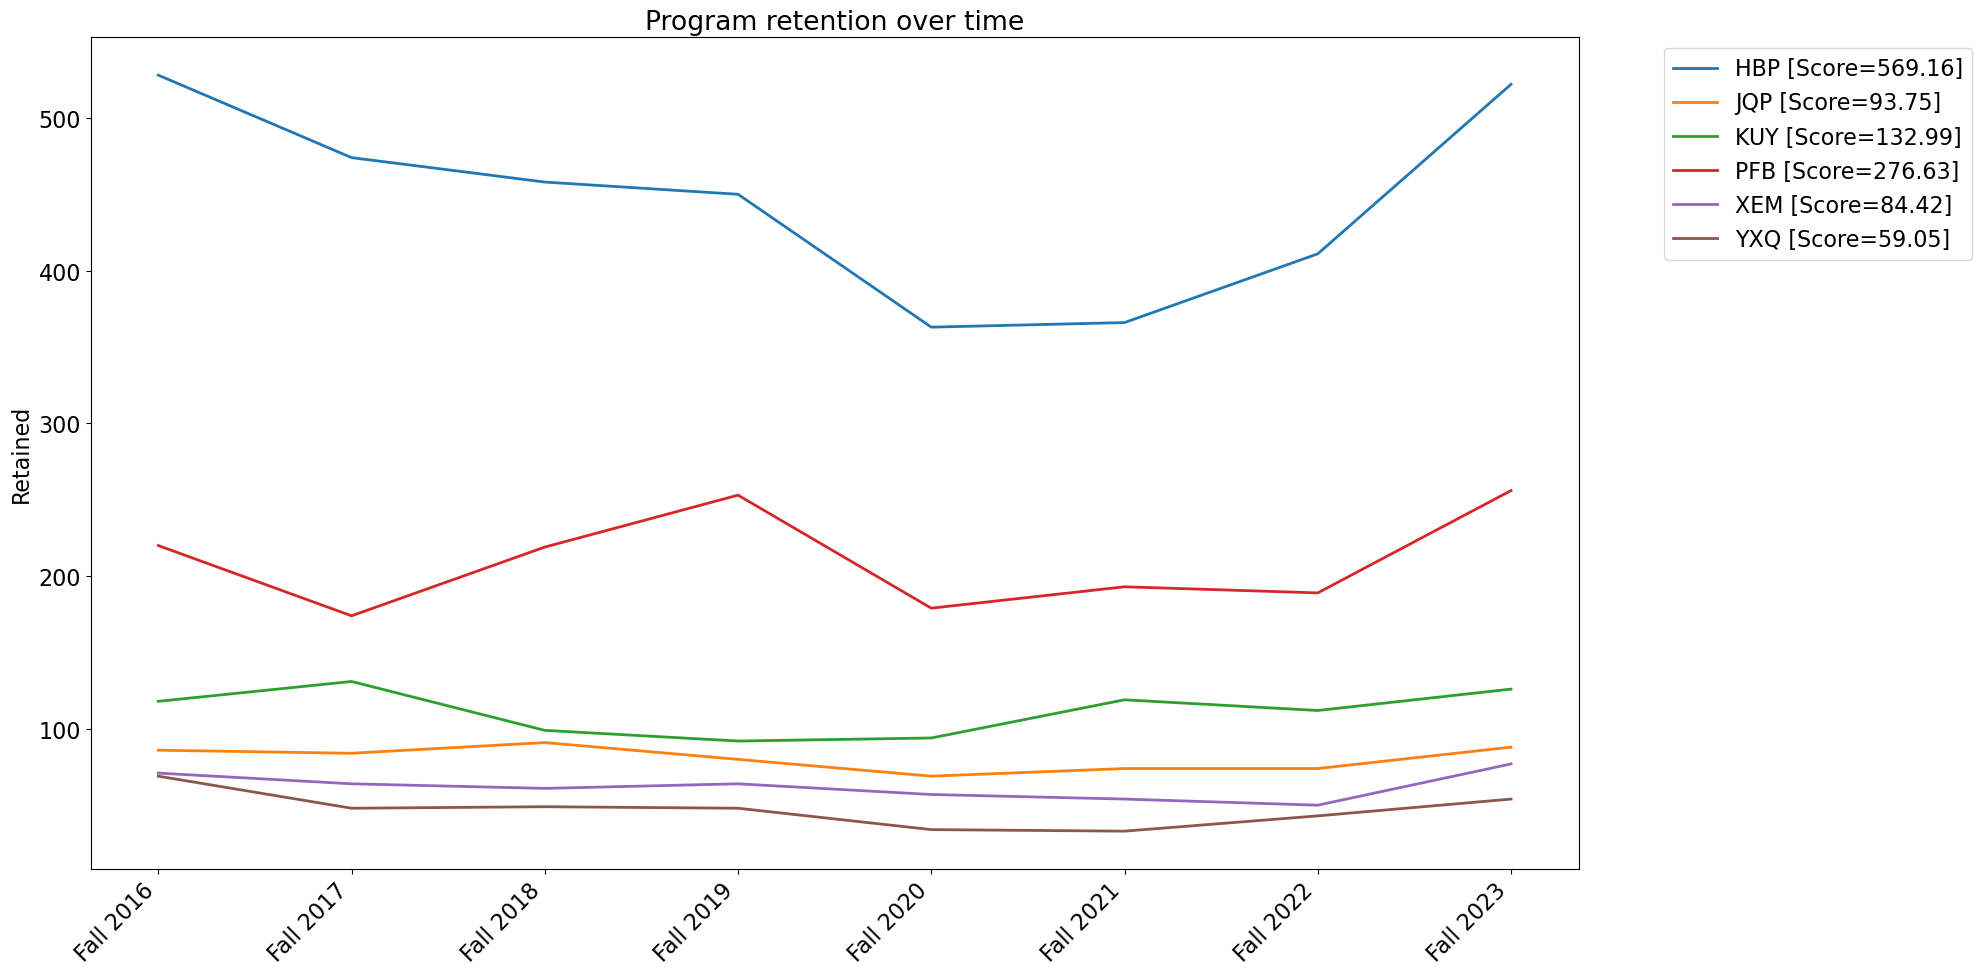

In [200]:
target='Retained'
program_list=['FOR', 'AEX', 'AFX']
df2=df.loc[df['Program'].isin(top_programs_list)]
trends_retained_df2, missing_retained_df2 = retention_variation_curves(  df2,
                                                                         var_list=var_list,
                                                                         target=target,
                                                                         lamda=lamda, 
                                                                         horizon=horizon)

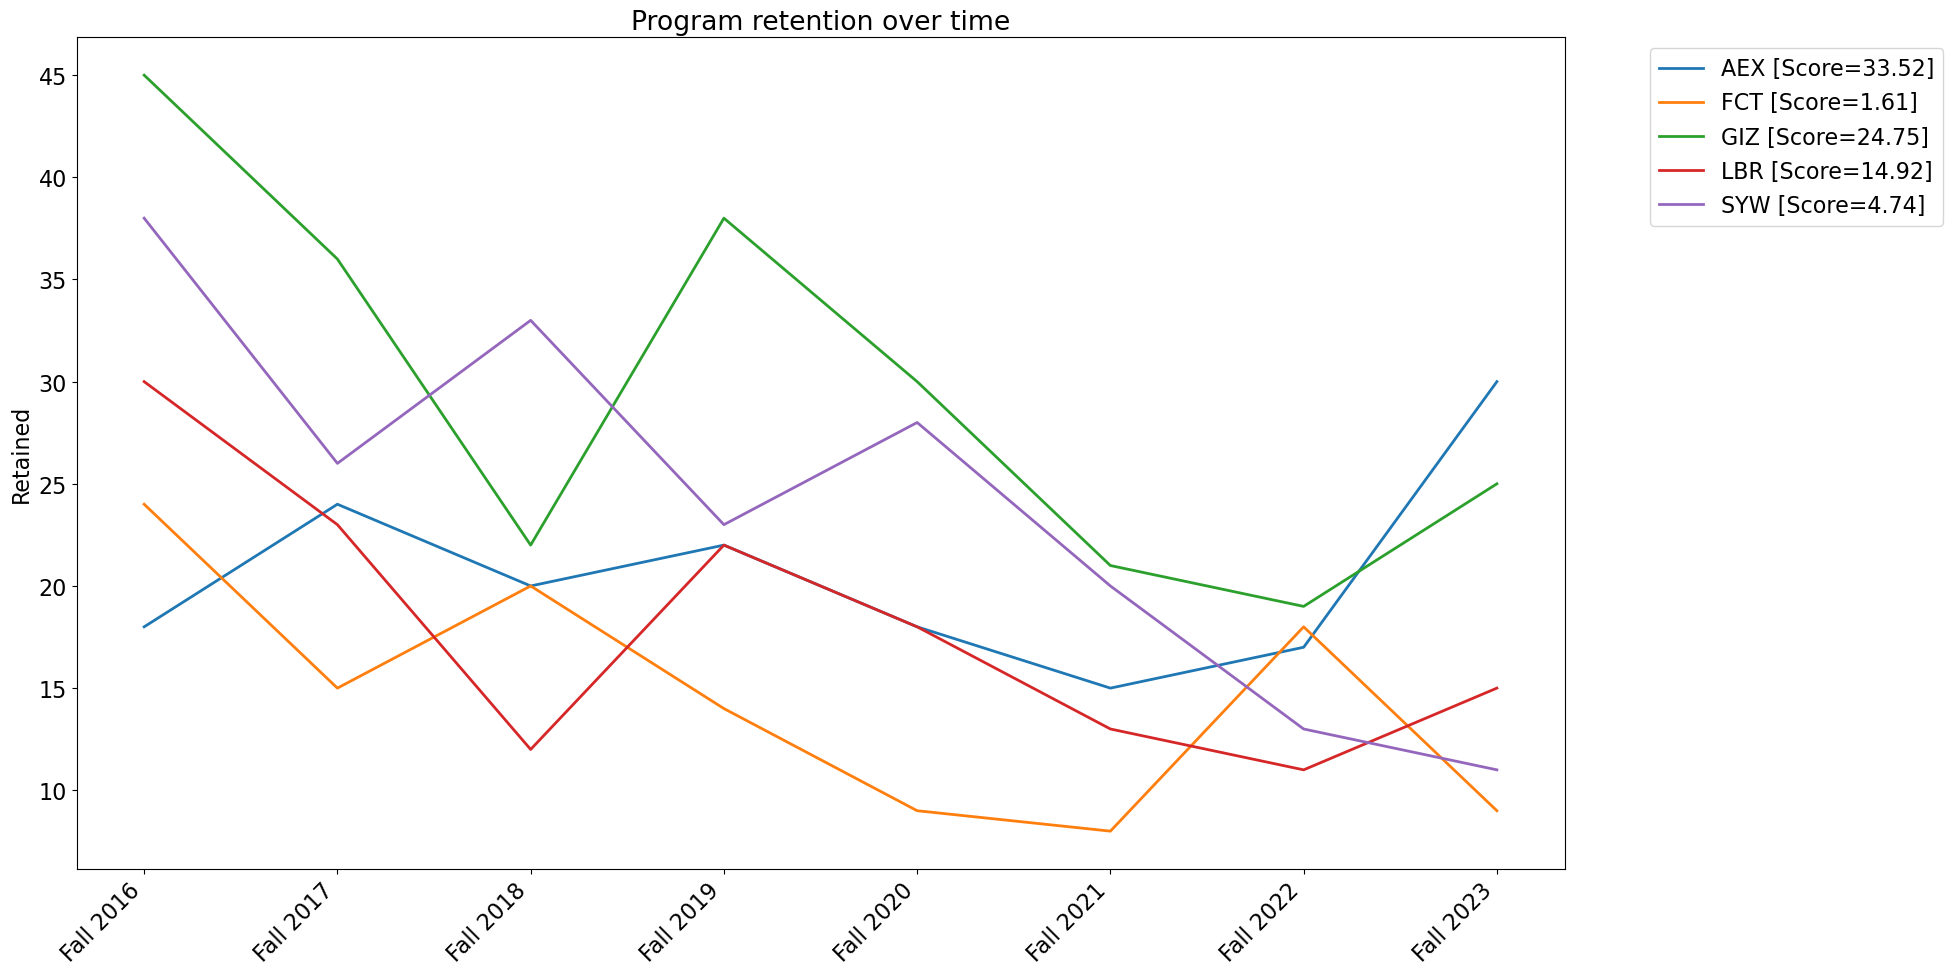

In [201]:
target='Retained'
program_list=['FOR', 'AEX', 'AFX']
df2=df.loc[df['Program'].isin(worst_programs_list)]
trends_retained_df2, missing_retained_df2 = retention_variation_curves(  df2,
                                                                         var_list=var_list,
                                                                         target=target,
                                                                         lamda=lamda, 
                                                                         horizon=horizon)

# SYNTAX

### plotly

In [ ]:
# plot the signal
import plotly.express as px
fig = px.bar(PN_trends_retained, 
             x="Program", 
             y="score", 
             color="NationalStatus",
             title='Retention Trends (Fall 2024)')
fig.show()


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(name="DOMESTIC", x=PN_trends_retained_dometic['Program'], y=PN_trends_retained_dometic['score']))
fig.add_trace(go.Bar(name="INTERNATIONAL", x=PN_trends_retained_international['Program'], y=PN_trends_retained_international['score']))
fig.show()

### Pandas queries

In [ ]:
target='Retained'
# target='retention_percentage'

filter_tag= df.groupby(['School'], as_index=False)[target].mean()
filter_tag

In [ ]:
pd.set_option("max_colwidth", None)
PN_trends_retained.drop(columns=['score_label','x'])

In [ ]:
df.groupby(['AdmitTerm', 'School'], as_index=False)['Retained'].std()

### SQL queries

In [ ]:
arima_df = sqldf(f"SELECT * \
                 FROM df \
                 WHERE Retained >0   \
                  AND  AdmitTerm IN {convert_list_quesry_format(AdmitTerm_list)} \
                  AND  School IN {convert_list_quesry_format(schools_list)} \
                  AND  Program IN {convert_list_quesry_format(programs_list)} \
                  AND  NationalStatus IN {convert_list_quesry_format(nationalStatus_list)} \
                 ORDER BY AdmitTerm \
                 LIMIT 10;")

### sns.barplot text of another column

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
# df_1, selected_items = select_topN_worstN_rows(PN_trends_retained, N=5)
df_ = PN_trends_retained.iloc[:10]
df_ = df_.reset_index().drop(columns=['index'])
ax = sns.barplot(
    x='Program', 
    y="score",
    hue='NationalStatus',
    data=df_,
    alpha=1)
# ax.set_ylim(0, df_['total reach - log(x)'].max() * 1.15)
try:
    for idx, p in enumerate(ax.patches):
        avg_retention=df_.iloc[idx]["average-retention-rate"]
        score=df_.iloc[idx]['score']
        print(f'{score} --> p{idx}={p} ')
        ax.annotate(format( score, '.2f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 9),
            textcoords='offset points')
except:
    print(f'skipp the annotations')
fig = plt.gcf()
fig.set_size_inches(15, 7)
ax.set_title("Testing")
plt.tight_layout()
plt.show()

### visualization with filling

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 5)
with sns.axes_style("darkgrid"):
    epochs = list(range(101))
    for i in range(5):
        meanst = np.array(means.ix[i].values[3:-1], dtype=np.float64)
        
        sdt = np.array(stds.ix[i].values[3:-1], dtype=np.float64)
        ax.plot(epochs, meanst, label=means.ix[i]["label"], c=clrs[i])
        ax.fill_between(epochs, meanst-sdt, meanst+sdt ,alpha=0.3, facecolor=clrs[i])
    ax.legend()
    ax.set_yscale('log')

### save outputs

In [ ]:
# define the experiment 
experiemnt=f'Trending(Program,' + '-'.join(df_['NationalStatus'].unique()) + ')'

# visualize the plots 
fig = plt.figure(figsize=(19.20,10.80))

output_filename=f'outputs/{experiemnt}.svg'
fig.savefig(output_filename, format='svg', dpi=1200)

### testing codes

In [ ]:
df[df['School']=='School G'].sort_values(by=['retention rate'])